# Imports

In [2]:
import os
import random
import time
import collections
import torch
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl
import json

from innvariant_dgl.deepgg import DeepGG
from scipy.stats import entropy
from innvariant_dgl.dataset import ConstructionSequenceDataset, generate_ba_model_construction_sequence, graph_to_construction_sequence, construction_sequence_to_graph, generate_ws_model_construction_sequence
from tqdm import tqdm

Using backend: pytorch


# Utility Functions

In [16]:
def count_graphs_degree(graph_list: list):
    degree_count = collections.Counter()

    for graph in graph_list:
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
        degree_count.update(degree_sequence)
    return degree_count

def count_cs_degree(ds_construction_sequences: list):
    return count_graphs_degree([construction_sequence_to_graph(seq) for seq in ds_construction_sequences])

def graph_degree_counter_to_histogram(counter_degree: collections.Counter, degrees_sorted: list=None):
    if degrees_sorted is None:
        degrees_sorted = sorted([d for d in sorted(counter_degree)])
        
    return [counter_degree.get(d) if counter_degree.get(d) is not None else 0 for d in degrees_sorted]

def get_degree_histogram(graph_list: list, degrees_sorted: list=None):
    counter_degree = count_graphs_degree(graph_list)

    return graph_degree_counter_to_histogram(counter_degree(graph_list), degrees_sorted)

def plot_count(count: collections.Counter, title='', label=''):
    deg, cnt = zip(*count.items())
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title('Histogram %s' % title)
    plt.ylabel('Count')
    plt.xlabel(label)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

def kl_divergence(p, q):    
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Data Preprocessing / Loading

In [4]:
drogon_base_path = '/media/data/computations/inn02-deep-graph-learning/drogon/'

drogon_generated_files = []
for filename in os.listdir(drogon_base_path):
    if "generated" in filename and filename.endswith(".json") and os.path.getsize(os.path.join(drogon_base_path, filename)) > 0:
        drogon_generated_files.append(filename)

In [5]:
mackenzie_base_path = '/media/data/computations/inn02-deep-graph-learning/mackenzie/'

mackenzie_generated_files = []
for filename in os.listdir(mackenzie_base_path):
    if "generated" in filename and filename.endswith(".json") and os.path.getsize(os.path.join(mackenzie_base_path, filename)) > 0:
        mackenzie_generated_files.append(filename)

print(mackenzie_generated_files[:5])

['deepgg-t1589810063-generated-generate_seqs_erdos_renyi_bfs.json', 'deepgg-t1589810059-generated-generate_seqs_watts_strogatz_dfs.json', 'deepgg-t1589473704-generated-generate_seqs_barabasi_albert_bfs.json', 'deepgg-t1589473382-generated-generate_seqs_erdos_renyi_dfs.json', 'deepgg-t1589473681-generated-generate_seqs_barabasi_albert_process.json']


In [6]:
computations = {
    mackenzie_base_path: mackenzie_generated_files,
    drogon_base_path: drogon_generated_files
}

In [7]:
model_infos = {}
for comp_base_path in computations:
    print(comp_base_path)
    files_generated = computations[comp_base_path]
    
    for filename in files_generated:
        print(filename)
        name_parts = filename.split('-')
        prefix = '-'.join(name_parts[0:2])
        file_type = name_parts[2]
        generator = name_parts[-1].replace('.json', '')

        # Load meta data for model
        meta_file_name = prefix + '-metadata-' + generator + '.json'
        meta_file_path = os.path.join(comp_base_path, meta_file_name)
        with open(meta_file_path, 'r') as mh:
            meta_info = json.load(mh)

        # Load used dataset for model
        ds_file_name = prefix + '-ds-1000-' + generator + '.json'
        ds_file_path = os.path.join(comp_base_path, ds_file_name)
        with open(ds_file_path, 'r') as dsh:
            data_dataset = json.load(dsh)
        ds_cs = data_dataset['construction_sequences']
        ds_graphs = [construction_sequence_to_graph(seq) for seq in ds_cs]

        # Load generated graph construction sequences
        with open(os.path.join(comp_base_path, filename), 'r') as dd:
            data_generated = json.load(dd)
        generated_cs = data_generated['construction_sequences']
        generated_graphs = [construction_sequence_to_graph(seq) for seq in generated_cs]

        # Collect all infos
        model_infos[os.path.join(comp_base_path, filename)] = {
            'cs': generated_cs,
            'graphs': generated_graphs,
            'meta': meta_info,
            'ds_cs': ds_cs,
            'ds_graphs': ds_graphs
        }
    print()

/media/data/computations/inn02-deep-graph-learning/mackenzie/
deepgg-t1589810063-generated-generate_seqs_erdos_renyi_bfs.json
deepgg-t1589810059-generated-generate_seqs_watts_strogatz_dfs.json
deepgg-t1589473704-generated-generate_seqs_barabasi_albert_bfs.json
deepgg-t1589473382-generated-generate_seqs_erdos_renyi_dfs.json
deepgg-t1589473681-generated-generate_seqs_barabasi_albert_process.json
deepgg-t1589810061-generated-generate_seqs_erdos_renyi_bfs.json

/media/data/computations/inn02-deep-graph-learning/drogon/
deepgg-t1590680745-generated-generate_seqs_watts_strogatz_bfs.json
deepgg-t1590408156-generated-generate_seqs_barabasi_albert_dfs.json
deepgg-t1589299409-generated-generate_seqs_erdos_renyi_dfs.json
deepgg-t1590574430-generated-generate_seqs_watts_strogatz_dfs.json
deepgg-t1590414133-generated-generate_seqs_watts_strogatz_dfs.json
deepgg-t1590574307-generated-generate_seqs_erdos_renyi_dfs.json
deepgg-t1590680741-generated-generate_seqs_barabasi_albert_bfs.json
deepgg-t159068

In [8]:
models_erdos_renyi = []
models_watts_strogatz = []
models_barabasi_albert = []

for name in model_infos:
    #print(json.dumps(model_infos[name]['meta'], indent=1))
    if 'erdos_renyi' in name:
        models_erdos_renyi.append(name)
    elif 'watts_strogatz' in name:
        models_watts_strogatz.append(name)
    elif 'barabasi_albert' in name:
        models_barabasi_albert.append(name)
    else:
        print('Unknown type for file <%s>' % name)

In [22]:
def compare_model_infos(model_infos: dict, filepath: str):
    print(filepath)
    num_generated = len(model_infos[filepath]['graphs'])
    num_dataset = len(model_infos[filepath]['ds_graphs'])
    print('Generated graphs:', num_generated)
    print('Dataset graphs:', num_dataset)
    
    generated_graphs_degree = count_graphs_degree(model_infos[filepath]['graphs'])
    ds_graphs_degree = count_graphs_degree(model_infos[filepath]['ds_graphs'])
    
    plot_count(ds_graphs_degree)
    plot_count(generated_graphs_degree)
    
    degrees = set([d for d in sorted(generated_graphs_degree)] + [d for d in sorted(ds_graphs_degree)])
    sorted_degrees = sorted(degrees)
    hist_list_generated = np.array([generated_graphs_degree.get(d) if generated_graphs_degree.get(d) is not None else 0 for d in sorted_degrees])
    hist_list_dataset = np.array([ds_graphs_degree.get(d) if ds_graphs_degree.get(d) is not None else 0 for d in sorted_degrees])
    
    h2 = hist_list_dataset/num_dataset
    h1 = hist_list_generated/num_generated
    print(h1)
    print(h2)
    print('KL-divergence', kl_divergence(h2, h1))
    degree_entropy = entropy(pk=h2, qk=h1)
    print('Entropy', degree_entropy)
    print('Degree entropy sufficiently small?', degree_entropy < 0.001)

# Erdos-Renyi Degree Analysis

In [9]:
models_erdos_renyi

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810063-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473382-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810061-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299409-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574307-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680725-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408105-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680750-generated-generate_seqs_erdos_

In [10]:
models_erdos_renyi_dfs = [name for name in models_erdos_renyi if '_dfs' in name]
models_erdos_renyi_dfs

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473382-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299409-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574307-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408105-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299418-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299414-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810207-generated-generate_seqs_erdos_renyi_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408101-generated-generate_seqs_erdos_renyi_

/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473382-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


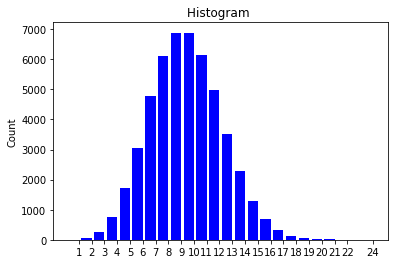

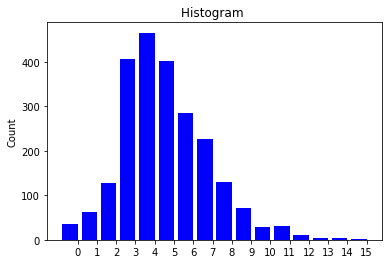

[0.18  0.315 0.635 2.03  2.33  2.015 1.43  1.13  0.65  0.36  0.145 0.16
 0.055 0.02  0.015 0.01  0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.000e+00 7.000e-03 7.100e-02 2.600e-01 7.590e-01 1.713e+00 3.047e+00
 4.793e+00 6.107e+00 6.885e+00 6.880e+00 6.140e+00 4.979e+00 3.515e+00
 2.290e+00 1.296e+00 6.930e-01 3.390e-01 1.170e-01 6.400e-02 2.800e-02
 1.200e-02 3.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299409-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


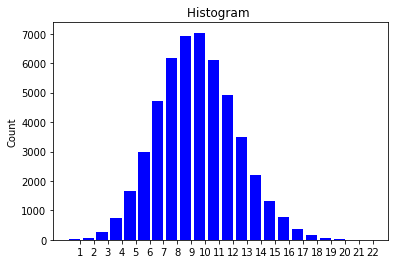

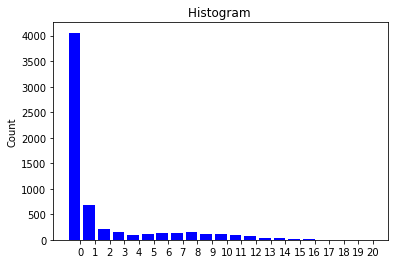

[2.0285e+01 3.4150e+00 1.0550e+00 7.5500e-01 5.0000e-01 5.9000e-01
 6.5000e-01 6.5000e-01 7.5000e-01 5.3500e-01 5.3000e-01 4.6000e-01
 3.2500e-01 2.1000e-01 2.0000e-01 1.1000e-01 6.0000e-02 1.5000e-02
 5.0000e-03 2.0000e-02 5.0000e-03 0.0000e+00 0.0000e+00]
[0.000e+00 1.200e-02 6.400e-02 2.670e-01 7.550e-01 1.653e+00 2.979e+00
 4.707e+00 6.161e+00 6.916e+00 7.037e+00 6.117e+00 4.921e+00 3.502e+00
 2.215e+00 1.316e+00 7.600e-01 3.610e-01 1.560e-01 6.300e-02 3.200e-02
 4.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574307-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


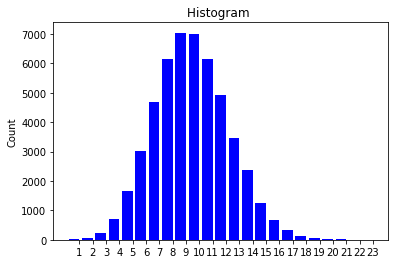

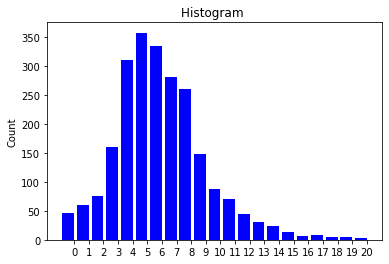

[0.235 0.3   0.38  0.8   1.555 1.79  1.675 1.41  1.305 0.74  0.435 0.355
 0.22  0.15  0.12  0.07  0.035 0.04  0.025 0.025 0.015 0.    0.    0.   ]
[0.000e+00 1.500e-02 6.900e-02 2.360e-01 7.020e-01 1.644e+00 3.014e+00
 4.671e+00 6.159e+00 7.045e+00 7.014e+00 6.158e+00 4.936e+00 3.462e+00
 2.360e+00 1.266e+00 6.860e-01 3.360e-01 1.340e-01 5.900e-02 1.700e-02
 1.300e-02 3.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408105-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


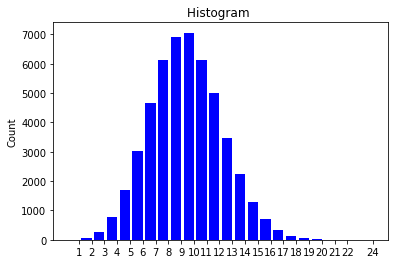

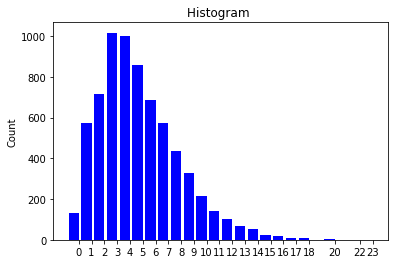

[6.650e-01 2.870e+00 3.570e+00 5.085e+00 5.015e+00 4.295e+00 3.445e+00
 2.875e+00 2.170e+00 1.650e+00 1.075e+00 7.000e-01 5.050e-01 3.450e-01
 2.550e-01 1.250e-01 1.050e-01 5.000e-02 3.500e-02 0.000e+00 1.000e-02
 0.000e+00 5.000e-03 5.000e-03 0.000e+00]
[0.000e+00 6.000e-03 5.100e-02 2.630e-01 7.600e-01 1.680e+00 3.017e+00
 4.649e+00 6.135e+00 6.914e+00 7.055e+00 6.125e+00 5.015e+00 3.485e+00
 2.257e+00 1.303e+00 7.070e-01 3.440e-01 1.440e-01 5.700e-02 2.500e-02
 4.000e-03 2.000e-03 0.000e+00 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299418-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


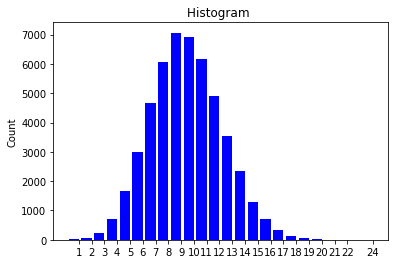

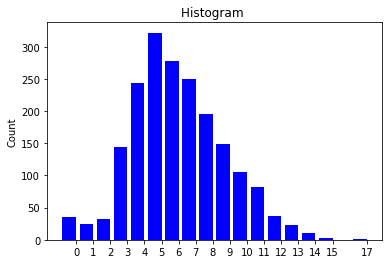

[0.175 0.12  0.165 0.72  1.22  1.61  1.39  1.25  0.975 0.745 0.525 0.41
 0.185 0.115 0.05  0.015 0.    0.005 0.    0.    0.    0.    0.    0.   ]
[0.000e+00 1.100e-02 7.300e-02 2.460e-01 7.130e-01 1.662e+00 2.996e+00
 4.674e+00 6.074e+00 7.064e+00 6.929e+00 6.171e+00 4.910e+00 3.548e+00
 2.352e+00 1.277e+00 7.260e-01 3.400e-01 1.460e-01 5.300e-02 1.900e-02
 8.000e-03 5.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299414-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


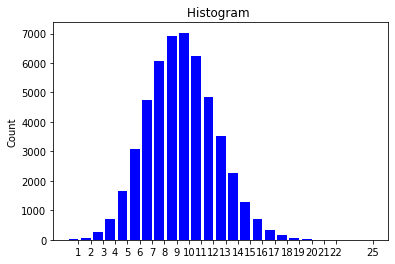

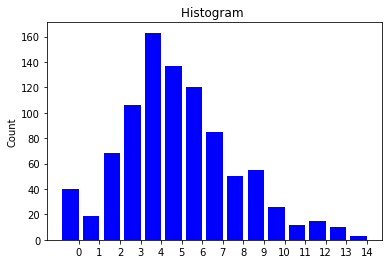

[0.2   0.095 0.34  0.53  0.815 0.685 0.6   0.425 0.25  0.275 0.13  0.06
 0.075 0.05  0.015 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.000e+00 1.400e-02 6.900e-02 2.730e-01 7.070e-01 1.646e+00 3.093e+00
 4.730e+00 6.060e+00 6.916e+00 7.027e+00 6.231e+00 4.846e+00 3.539e+00
 2.268e+00 1.288e+00 6.910e-01 3.440e-01 1.630e-01 7.100e-02 1.700e-02
 5.000e-03 1.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810207-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


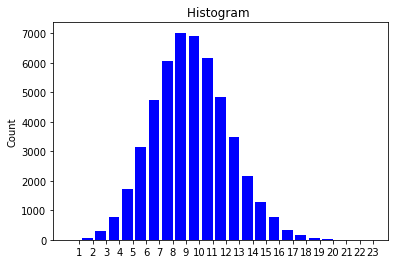

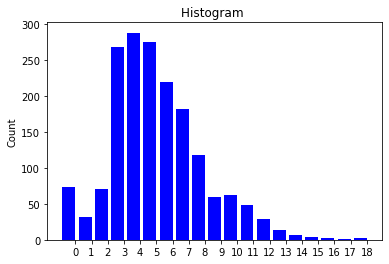

[0.37  0.16  0.355 1.34  1.44  1.375 1.095 0.91  0.59  0.295 0.31  0.245
 0.145 0.07  0.03  0.02  0.01  0.005 0.01  0.    0.    0.    0.    0.   ]
[0.000e+00 8.000e-03 6.600e-02 2.820e-01 7.570e-01 1.713e+00 3.138e+00
 4.754e+00 6.058e+00 7.026e+00 6.900e+00 6.164e+00 4.835e+00 3.492e+00
 2.175e+00 1.292e+00 7.600e-01 3.420e-01 1.520e-01 5.500e-02 1.800e-02
 7.000e-03 3.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408101-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


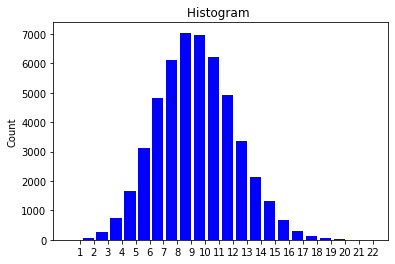

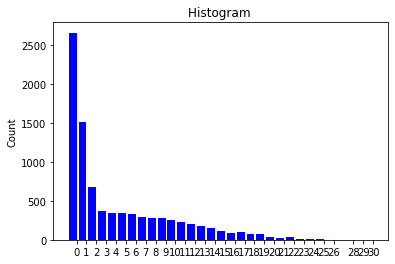

[1.327e+01 7.540e+00 3.380e+00 1.825e+00 1.720e+00 1.705e+00 1.665e+00
 1.440e+00 1.400e+00 1.425e+00 1.250e+00 1.120e+00 1.010e+00 9.050e-01
 7.300e-01 5.700e-01 4.400e-01 5.200e-01 3.950e-01 3.750e-01 1.900e-01
 1.350e-01 1.550e-01 7.500e-02 5.000e-02 2.000e-02 1.000e-02 1.000e-02
 5.000e-03 5.000e-03]
[0.000e+00 9.000e-03 5.800e-02 2.640e-01 7.350e-01 1.673e+00 3.117e+00
 4.813e+00 6.124e+00 7.039e+00 6.976e+00 6.203e+00 4.923e+00 3.373e+00
 2.150e+00 1.332e+00 6.720e-01 3.040e-01 1.400e-01 6.200e-02 2.200e-02
 8.000e-03 2.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
KL-divergence 64.66574595332465
Entropy 1.1504137767622802
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680714-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


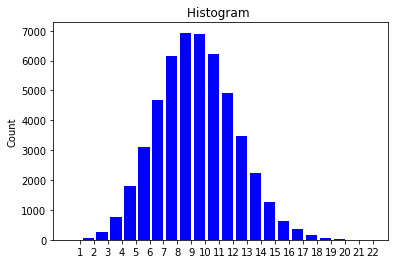

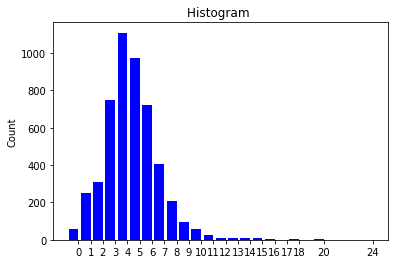

[2.850e-01 1.250e+00 1.555e+00 3.730e+00 5.545e+00 4.865e+00 3.620e+00
 2.035e+00 1.045e+00 4.850e-01 2.900e-01 1.200e-01 4.500e-02 3.500e-02
 3.500e-02 3.500e-02 3.000e-02 5.000e-03 1.000e-02 0.000e+00 1.500e-02
 0.000e+00 0.000e+00 5.000e-03]
[0.000e+00 9.000e-03 7.300e-02 2.540e-01 7.730e-01 1.803e+00 3.097e+00
 4.668e+00 6.145e+00 6.934e+00 6.901e+00 6.235e+00 4.910e+00 3.462e+00
 2.241e+00 1.250e+00 6.400e-01 3.640e-01 1.470e-01 6.100e-02 2.400e-02
 8.000e-03 1.000e-03 0.000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810150-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


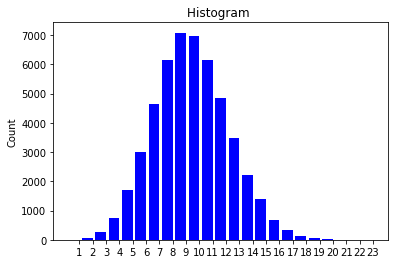

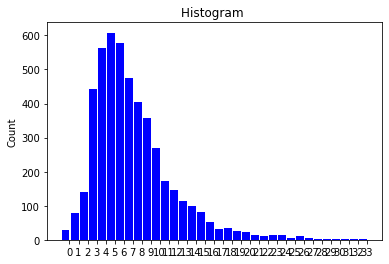

[0.15  0.395 0.705 2.21  2.82  3.04  2.89  2.375 2.02  1.79  1.35  0.87
 0.735 0.575 0.495 0.415 0.26  0.165 0.175 0.125 0.11  0.065 0.055 0.075
 0.075 0.03  0.05  0.03  0.015 0.015 0.01  0.01  0.01  0.005]
[0.000e+00 5.000e-03 7.100e-02 2.650e-01 7.470e-01 1.689e+00 3.003e+00
 4.637e+00 6.151e+00 7.084e+00 6.962e+00 6.148e+00 4.865e+00 3.492e+00
 2.224e+00 1.383e+00 6.890e-01 3.400e-01 1.330e-01 6.800e-02 3.200e-02
 7.000e-03 2.000e-03 2.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 61.7922848232738
Entropy 0.5067014621665453
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414191-generated-generate_seqs_erdos_renyi_dfs.json
Generated graphs: 200
Dataset graphs: 1000


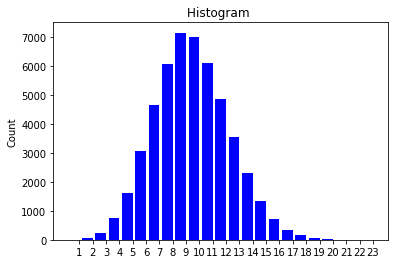

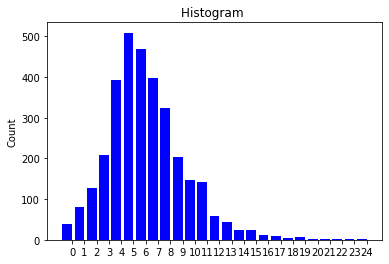

[0.195 0.405 0.64  1.04  1.97  2.545 2.34  1.99  1.625 1.02  0.735 0.705
 0.29  0.22  0.125 0.115 0.065 0.05  0.02  0.03  0.005 0.015 0.005 0.015
 0.005]
[0.000e+00 7.000e-03 6.800e-02 2.360e-01 7.420e-01 1.624e+00 3.077e+00
 4.635e+00 6.051e+00 7.139e+00 7.000e+00 6.100e+00 4.857e+00 3.542e+00
 2.309e+00 1.326e+00 7.070e-01 3.320e-01 1.500e-01 5.800e-02 3.000e-02
 6.000e-03 2.000e-03 1.000e-03 0.000e+00]
KL-divergence 89.7688432154913
Entropy 0.6665674409261492
Degree entropy sufficiently small? False


In [23]:
for filepath in models_erdos_renyi_dfs:
    compare_model_infos(model_infos, filepath)

In [25]:
models_erdos_renyi_bfs = [name for name in models_erdos_renyi if '_bfs' in name]
models_erdos_renyi_bfs

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810063-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810061-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680725-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680750-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299796-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414058-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408056-generated-generate_seqs_erdos_renyi_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680737-generated-generate_seqs_erdos_ren

/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810063-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


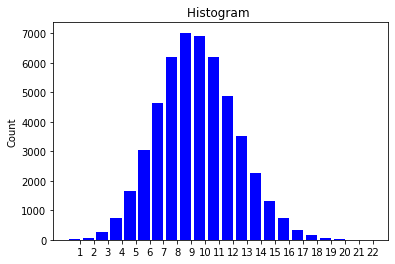

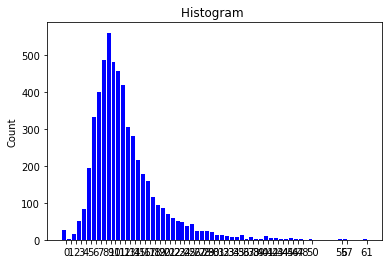

[0.135 0.015 0.085 0.255 0.42  0.975 1.67  2.    2.43  2.805 2.41  2.285
 2.095 1.525 1.41  1.075 0.885 0.8   0.585 0.475 0.43  0.345 0.29  0.25
 0.235 0.185 0.21  0.12  0.125 0.12  0.105 0.065 0.065 0.055 0.04  0.035
 0.065 0.015 0.04  0.015 0.015 0.05  0.025 0.02  0.005 0.005 0.02  0.015
 0.015 0.01  0.005 0.01  0.005]
[0.000e+00 1.200e-02 5.600e-02 2.570e-01 7.320e-01 1.660e+00 3.038e+00
 4.639e+00 6.193e+00 7.023e+00 6.905e+00 6.202e+00 4.863e+00 3.518e+00
 2.261e+00 1.317e+00 7.250e-01 3.400e-01 1.720e-01 6.300e-02 1.600e-02
 5.000e-03 3.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 40.19730680188049
Entropy 0.20045682740819964
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-g

/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


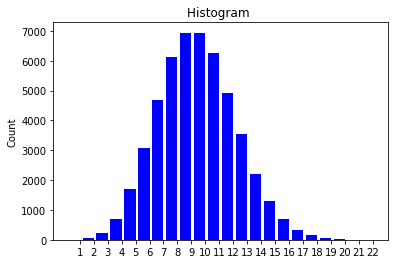

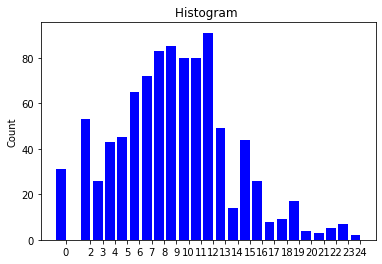

[0.155 0.    0.265 0.13  0.215 0.225 0.325 0.36  0.415 0.425 0.4   0.4
 0.455 0.245 0.07  0.22  0.13  0.04  0.045 0.085 0.02  0.015 0.025 0.035
 0.01 ]
[0.000e+00 1.000e-02 7.300e-02 2.370e-01 7.110e-01 1.700e+00 3.069e+00
 4.680e+00 6.135e+00 6.937e+00 6.934e+00 6.254e+00 4.912e+00 3.544e+00
 2.211e+00 1.296e+00 7.020e-01 3.440e-01 1.470e-01 5.900e-02 3.400e-02
 9.000e-03 2.000e-03 0.000e+00 0.000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680725-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


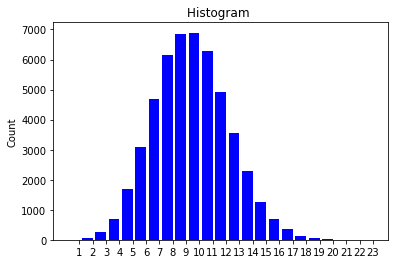

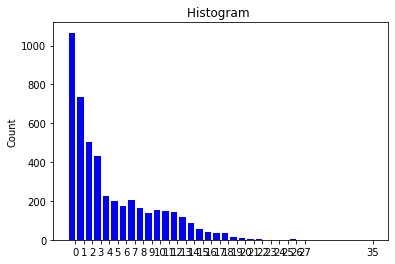

[5.330e+00 3.675e+00 2.515e+00 2.150e+00 1.115e+00 9.950e-01 8.650e-01
 1.025e+00 8.250e-01 7.000e-01 7.700e-01 7.400e-01 7.250e-01 5.850e-01
 4.450e-01 2.850e-01 2.100e-01 1.650e-01 1.650e-01 6.000e-02 4.500e-02
 2.000e-02 1.500e-02 5.000e-03 5.000e-03 5.000e-03 1.000e-02 5.000e-03
 5.000e-03]
[0.000e+00 8.000e-03 5.800e-02 2.590e-01 6.990e-01 1.680e+00 3.082e+00
 4.695e+00 6.155e+00 6.866e+00 6.893e+00 6.286e+00 4.934e+00 3.550e+00
 2.283e+00 1.257e+00 7.080e-01 3.460e-01 1.300e-01 6.600e-02 2.800e-02
 9.000e-03 3.000e-03 2.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]
KL-divergence 89.9282092920509
Entropy 1.0420059457646431
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680750-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


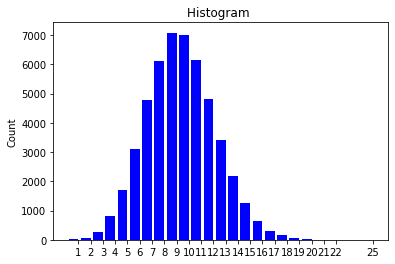

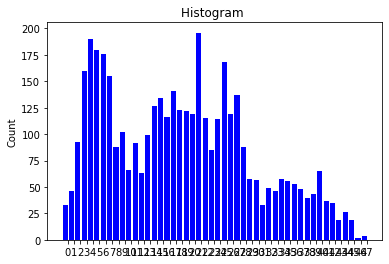

[0.165 0.23  0.465 0.8   0.95  0.9   0.88  0.775 0.44  0.51  0.33  0.46
 0.315 0.495 0.635 0.67  0.58  0.705 0.615 0.61  0.595 0.98  0.575 0.425
 0.57  0.84  0.595 0.685 0.44  0.29  0.285 0.165 0.245 0.23  0.29  0.28
 0.265 0.24  0.2   0.215 0.325 0.185 0.175 0.095 0.13  0.095 0.01  0.02 ]
[0.000e+00 1.100e-02 5.600e-02 2.640e-01 8.020e-01 1.696e+00 3.104e+00
 4.767e+00 6.121e+00 7.083e+00 7.002e+00 6.166e+00 4.819e+00 3.411e+00
 2.192e+00 1.257e+00 6.530e-01 3.180e-01 1.700e-01 6.500e-02 3.400e-02
 5.000e-03 2.000e-03 0.000e+00 0.000e+00 1.000e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 107.76549834328148
Entropy 1.2866813210522345
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299796-generated-generate_seqs_erdos_renyi_bfs.jso

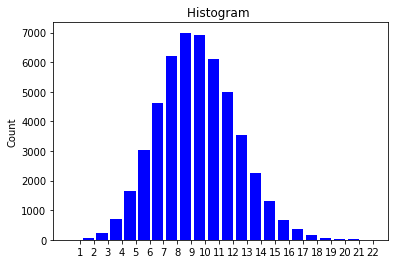

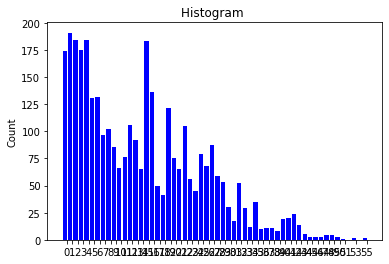

[0.87  0.955 0.92  0.875 0.92  0.655 0.66  0.485 0.51  0.43  0.33  0.38
 0.53  0.46  0.325 0.915 0.68  0.25  0.205 0.61  0.375 0.325 0.525 0.28
 0.225 0.395 0.34  0.435 0.295 0.265 0.15  0.085 0.26  0.145 0.06  0.175
 0.05  0.055 0.055 0.04  0.095 0.1   0.12  0.07  0.025 0.015 0.015 0.015
 0.02  0.02  0.015 0.005 0.01  0.01 ]
[0.000e+00 1.000e-02 7.300e-02 2.160e-01 7.000e-01 1.652e+00 3.049e+00
 4.625e+00 6.222e+00 6.997e+00 6.928e+00 6.117e+00 4.994e+00 3.530e+00
 2.256e+00 1.324e+00 6.800e-01 3.660e-01 1.560e-01 6.800e-02 2.400e-02
 1.100e-02 2.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 112.15843163268526
Entropy 1.1664156783384891
Degree entropy sufficiently small? False
/media/data/computatio

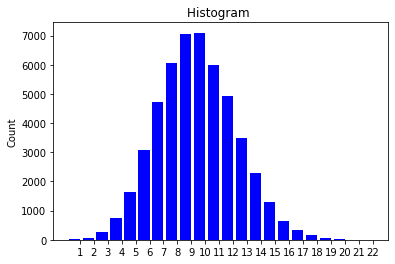

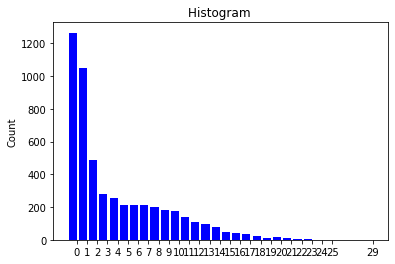

[6.325e+00 5.260e+00 2.435e+00 1.385e+00 1.270e+00 1.050e+00 1.065e+00
 1.070e+00 1.010e+00 9.000e-01 8.750e-01 7.000e-01 5.550e-01 4.750e-01
 3.900e-01 2.350e-01 2.050e-01 1.750e-01 1.150e-01 7.000e-02 8.000e-02
 4.000e-02 3.000e-02 2.000e-02 5.000e-03 5.000e-03 5.000e-03]
[0.000e+00 1.100e-02 7.000e-02 2.700e-01 7.410e-01 1.649e+00 3.072e+00
 4.724e+00 6.066e+00 7.068e+00 7.097e+00 6.006e+00 4.920e+00 3.505e+00
 2.281e+00 1.304e+00 6.420e-01 3.270e-01 1.610e-01 5.400e-02 2.300e-02
 6.000e-03 1.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 88.00171304610492
Entropy 1.0965562875903232
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408056-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


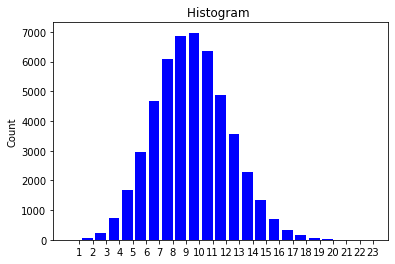

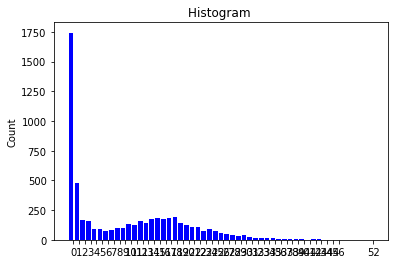

[8.715e+00 2.375e+00 8.350e-01 8.050e-01 4.650e-01 4.450e-01 3.750e-01
 4.200e-01 5.000e-01 4.850e-01 6.750e-01 6.150e-01 8.050e-01 7.150e-01
 8.750e-01 9.100e-01 8.650e-01 9.250e-01 9.600e-01 7.100e-01 6.300e-01
 5.550e-01 5.200e-01 3.900e-01 4.450e-01 3.650e-01 3.050e-01 2.550e-01
 2.100e-01 1.550e-01 1.900e-01 1.050e-01 7.500e-02 6.500e-02 9.000e-02
 5.500e-02 3.000e-02 3.500e-02 2.000e-02 1.500e-02 1.500e-02 5.000e-03
 2.000e-02 1.500e-02 1.000e-02 1.000e-02 5.000e-03 5.000e-03]
[0.000e+00 1.000e-02 6.500e-02 2.310e-01 7.290e-01 1.664e+00 2.956e+00
 4.664e+00 6.091e+00 6.875e+00 6.974e+00 6.356e+00 4.893e+00 3.574e+00
 2.281e+00 1.349e+00 7.020e-01 3.410e-01 1.540e-01 6.200e-02 1.800e-02
 7.000e-03 3.000e-03 1.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 100.193735

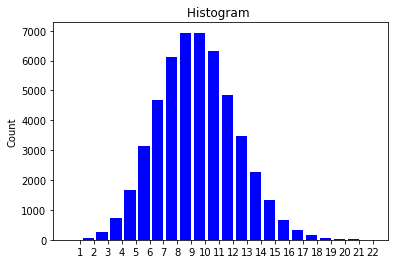

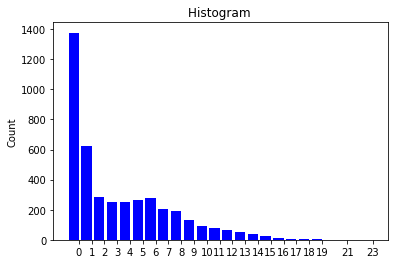

[6.880e+00 3.130e+00 1.425e+00 1.265e+00 1.245e+00 1.325e+00 1.395e+00
 1.035e+00 9.450e-01 6.600e-01 4.650e-01 3.850e-01 3.150e-01 2.650e-01
 1.800e-01 1.150e-01 7.000e-02 3.000e-02 2.000e-02 1.000e-02 0.000e+00
 5.000e-03 0.000e+00 5.000e-03]
[0.000e+00 1.000e-02 6.000e-02 2.600e-01 7.220e-01 1.662e+00 3.133e+00
 4.674e+00 6.119e+00 6.926e+00 6.932e+00 6.315e+00 4.851e+00 3.469e+00
 2.279e+00 1.323e+00 6.750e-01 3.420e-01 1.540e-01 5.600e-02 2.200e-02
 1.300e-02 3.000e-03 0.000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414067-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


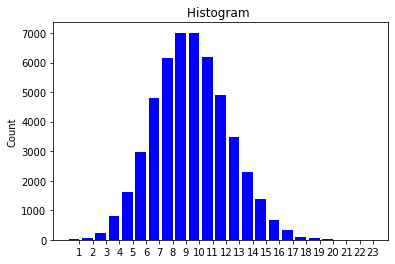

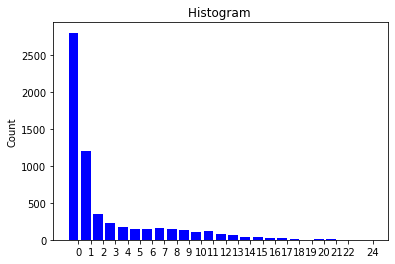

[1.3985e+01 6.0100e+00 1.7750e+00 1.1050e+00 8.7000e-01 7.4500e-01
 7.3000e-01 7.9500e-01 7.2000e-01 6.4500e-01 5.1500e-01 5.9000e-01
 3.9000e-01 3.1000e-01 2.1500e-01 1.7000e-01 1.4500e-01 1.1000e-01
 7.0000e-02 2.0000e-02 2.5000e-02 3.0000e-02 5.0000e-03 0.0000e+00
 5.0000e-03]
[0.000e+00 1.300e-02 7.000e-02 2.300e-01 7.920e-01 1.602e+00 2.969e+00
 4.784e+00 6.146e+00 7.003e+00 7.009e+00 6.172e+00 4.888e+00 3.478e+00
 2.281e+00 1.373e+00 6.720e-01 3.180e-01 1.080e-01 6.100e-02 1.900e-02
 9.000e-03 1.000e-03 1.000e-03 0.000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574301-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


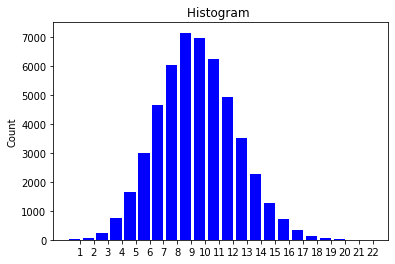

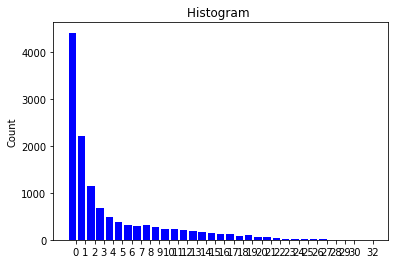

[2.209e+01 1.108e+01 5.745e+00 3.365e+00 2.380e+00 1.910e+00 1.615e+00
 1.465e+00 1.550e+00 1.400e+00 1.170e+00 1.105e+00 1.025e+00 9.150e-01
 8.800e-01 7.300e-01 6.500e-01 6.150e-01 3.700e-01 5.050e-01 3.000e-01
 2.650e-01 1.950e-01 1.150e-01 1.350e-01 5.000e-02 4.000e-02 3.500e-02
 2.000e-02 1.500e-02 1.500e-02 1.500e-02]
[0.000e+00 1.200e-02 7.500e-02 2.470e-01 7.430e-01 1.643e+00 2.980e+00
 4.648e+00 6.033e+00 7.139e+00 6.942e+00 6.236e+00 4.936e+00 3.518e+00
 2.258e+00 1.283e+00 7.150e-01 3.430e-01 1.430e-01 6.700e-02 2.700e-02
 1.000e-02 1.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 62.84957955833667
Entropy 1.4683505872619973
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408015-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


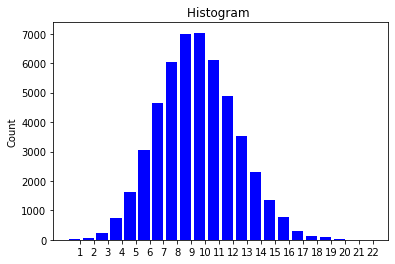

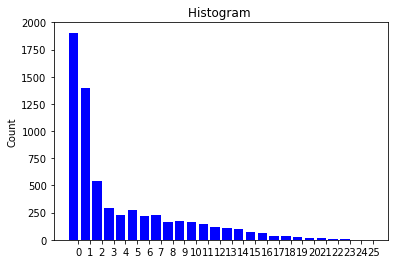

[9.525e+00 7.000e+00 2.715e+00 1.475e+00 1.150e+00 1.375e+00 1.095e+00
 1.125e+00 8.400e-01 8.500e-01 8.000e-01 7.450e-01 6.000e-01 5.300e-01
 4.800e-01 3.650e-01 3.300e-01 1.600e-01 1.550e-01 1.250e-01 7.000e-02
 7.000e-02 4.000e-02 2.500e-02 1.000e-02 5.000e-03]
[0.000e+00 1.300e-02 6.800e-02 2.440e-01 7.370e-01 1.629e+00 3.055e+00
 4.653e+00 6.044e+00 7.002e+00 7.037e+00 6.118e+00 4.897e+00 3.542e+00
 2.299e+00 1.337e+00 7.620e-01 3.060e-01 1.460e-01 7.900e-02 2.500e-02
 5.000e-03 2.000e-03 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 86.88516025566071
Entropy 1.280734254137934
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299334-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


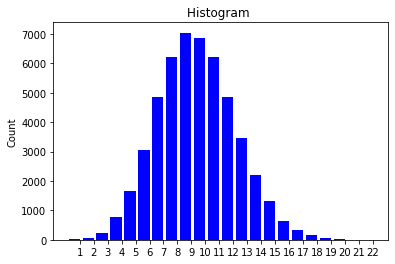

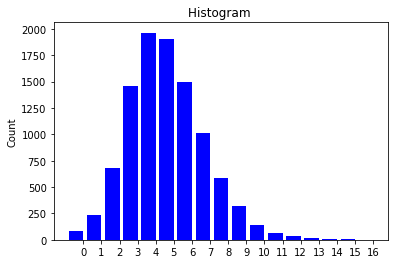

[4.350e-01 1.170e+00 3.420e+00 7.285e+00 9.820e+00 9.525e+00 7.490e+00
 5.080e+00 2.935e+00 1.605e+00 7.100e-01 3.150e-01 1.850e-01 9.000e-02
 4.500e-02 2.000e-02 5.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[0.000e+00 1.200e-02 4.900e-02 2.410e-01 7.590e-01 1.650e+00 3.043e+00
 4.856e+00 6.222e+00 7.043e+00 6.862e+00 6.227e+00 4.857e+00 3.449e+00
 2.205e+00 1.314e+00 6.460e-01 3.290e-01 1.520e-01 5.500e-02 2.200e-02
 6.000e-03 1.000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680742-generated-generate_seqs_erdos_renyi_bfs.json
Generated graphs: 200
Dataset graphs: 1000


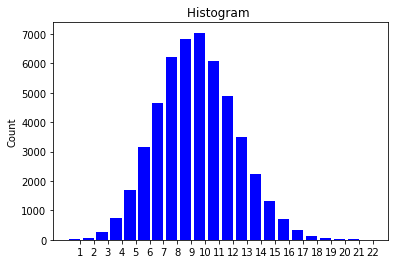

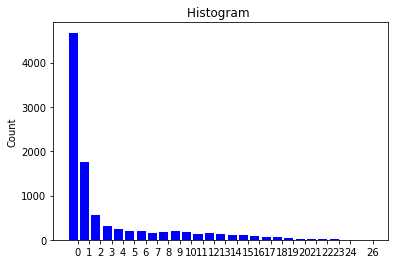

[2.3375e+01 8.8350e+00 2.7800e+00 1.5150e+00 1.2200e+00 9.8500e-01
 9.6500e-01 7.8000e-01 9.2500e-01 9.7500e-01 8.4500e-01 7.0000e-01
 8.0000e-01 6.0000e-01 5.0000e-01 4.9500e-01 4.2000e-01 2.7500e-01
 3.5000e-01 2.0500e-01 1.1500e-01 1.2000e-01 1.1500e-01 4.5000e-02
 2.0000e-02 5.0000e-03]
[0.000e+00 1.500e-02 5.000e-02 2.740e-01 7.290e-01 1.695e+00 3.170e+00
 4.661e+00 6.215e+00 6.846e+00 7.046e+00 6.095e+00 4.885e+00 3.487e+00
 2.225e+00 1.323e+00 6.990e-01 3.380e-01 1.450e-01 6.400e-02 1.700e-02
 1.800e-02 3.000e-03 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 84.94166451160692
Entropy 1.6572818630739032
Degree entropy sufficiently small? False


In [26]:
for filepath in models_erdos_renyi_bfs:
    compare_model_infos(model_infos, filepath)

# Watts Strogatz Analysis

In [27]:
models_watts_strogatz

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810059-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680745-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574430-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414133-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408146-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589366340-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408116-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680739-generated-gener

In [28]:
models_watts_strogatz_dfs = [name for name in models_watts_strogatz if '_dfs' in name]
models_watts_strogatz_dfs

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810059-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574430-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414133-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408146-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589366340-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408116-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680731-generated-generate_seqs_watts_strogatz_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810152-generated-gener

/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589810059-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


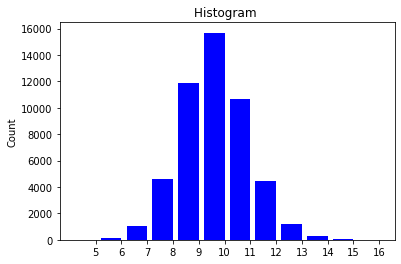

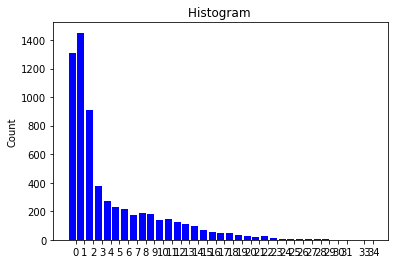

[6.540e+00 7.255e+00 4.540e+00 1.900e+00 1.375e+00 1.150e+00 1.070e+00
 8.650e-01 9.300e-01 9.000e-01 6.950e-01 7.400e-01 6.300e-01 5.700e-01
 4.750e-01 3.400e-01 2.800e-01 2.450e-01 2.350e-01 1.600e-01 1.450e-01
 9.500e-02 1.250e-01 5.500e-02 3.500e-02 4.000e-02 2.000e-02 3.500e-02
 1.500e-02 2.000e-02 1.000e-02 5.000e-03 5.000e-03 5.000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e-03
 1.1500e-01 1.0400e+00 4.6250e+00 1.1849e+01 1.5691e+01 1.0631e+01
 4.4720e+00 1.2340e+00 2.9200e-01 3.9000e-02 9.0000e-03 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 124.57630097339253
Entropy 2.0296492774337227
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574430-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


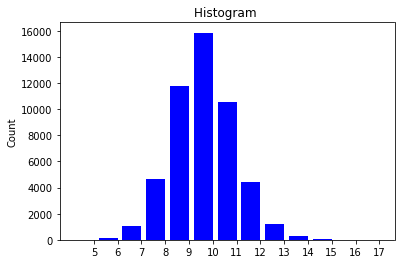

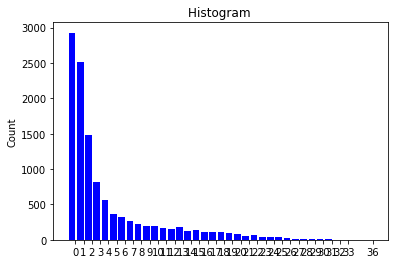

[1.464e+01 1.254e+01 7.380e+00 4.095e+00 2.795e+00 1.850e+00 1.615e+00
 1.305e+00 1.100e+00 9.550e-01 9.450e-01 8.150e-01 7.850e-01 8.750e-01
 6.550e-01 7.250e-01 5.350e-01 5.700e-01 5.450e-01 4.700e-01 3.950e-01
 2.850e-01 3.050e-01 1.950e-01 1.900e-01 2.300e-01 1.450e-01 5.000e-02
 8.000e-02 6.500e-02 2.500e-02 3.000e-02 1.500e-02 1.500e-02 5.000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-03
 1.0900e-01 1.0580e+00 4.6240e+00 1.1740e+01 1.5856e+01 1.0589e+01
 4.4290e+00 1.2480e+00 2.9500e-01 4.2000e-02 5.0000e-03 1.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 115.14743367485725
Entropy 2.4379165339076296
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414133-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Data

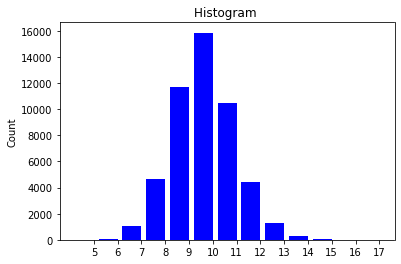

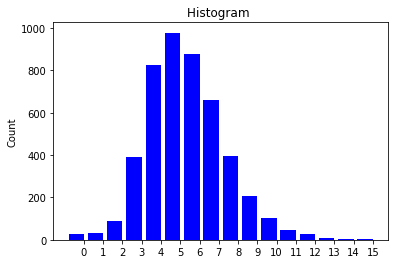

[0.135 0.16  0.435 1.96  4.12  4.89  4.39  3.295 1.98  1.03  0.505 0.24
 0.13  0.04  0.01  0.015 0.    0.   ]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e-03
 9.6000e-02 1.0620e+00 4.6930e+00 1.1727e+01 1.5859e+01 1.0460e+01
 4.4490e+00 1.3110e+00 2.7500e-01 5.3000e-02 6.0000e-03 3.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408146-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


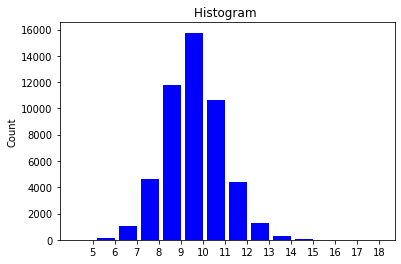

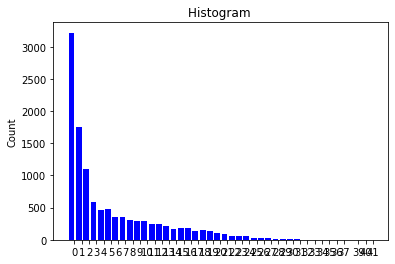

[1.6085e+01 8.8000e+00 5.4650e+00 2.9550e+00 2.2900e+00 2.3800e+00
 1.7650e+00 1.7850e+00 1.5550e+00 1.4750e+00 1.4500e+00 1.2050e+00
 1.2550e+00 1.0650e+00 8.4500e-01 9.1500e-01 9.0500e-01 6.9000e-01
 7.3500e-01 6.7500e-01 5.0500e-01 4.3000e-01 3.2000e-01 2.7500e-01
 2.6000e-01 1.5000e-01 1.2000e-01 1.5500e-01 7.0000e-02 4.5000e-02
 3.0000e-02 4.5000e-02 5.0000e-03 1.5000e-02 1.5000e-02 5.0000e-03
 1.0000e-02 5.0000e-03 5.0000e-03 1.5000e-02 5.0000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e-03
 1.2200e-01 1.0240e+00 4.6480e+00 1.1790e+01 1.5756e+01 1.0634e+01
 4.4260e+00 1.2490e+00 2.9200e-01 4.6000e-02 5.0000e-03 1.0000e-03
 1.0000e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 94.7003196768262
Entropy 2.0211675391532036
Degree entropy sufficien

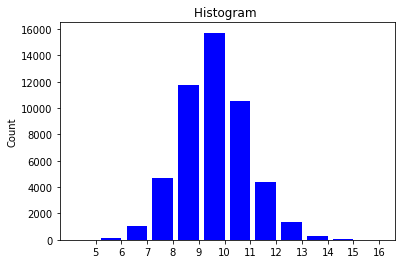

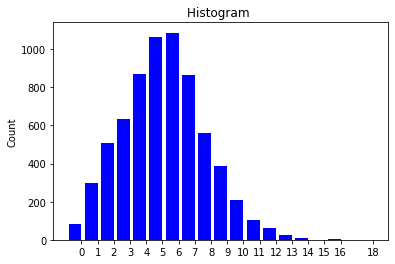

[4.050e-01 1.485e+00 2.540e+00 3.175e+00 4.335e+00 5.320e+00 5.430e+00
 4.320e+00 2.790e+00 1.930e+00 1.050e+00 5.100e-01 3.100e-01 1.350e-01
 6.000e-02 5.000e-03 1.000e-02 5.000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e-03
 1.3100e-01 1.0160e+00 4.7270e+00 1.1751e+01 1.5723e+01 1.0570e+01
 4.4070e+00 1.3230e+00 2.9500e-01 4.3000e-02 9.0000e-03 0.0000e+00]
KL-divergence 111.5982838086631
Entropy 1.8408471617720192
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408116-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


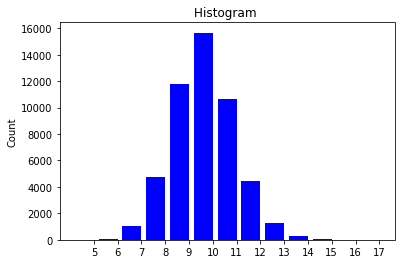

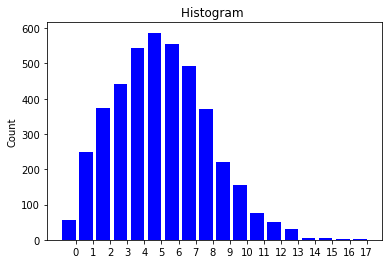

[0.28  1.24  1.865 2.205 2.72  2.935 2.78  2.47  1.85  1.1   0.77  0.38
 0.25  0.15  0.03  0.03  0.005 0.01 ]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.0000e-03
 9.5000e-02 1.0300e+00 4.7350e+00 1.1780e+01 1.5663e+01 1.0631e+01
 4.4260e+00 1.3070e+00 2.7900e-01 3.7000e-02 8.0000e-03 1.0000e-03]
KL-divergence 129.89583009432423
Entropy 1.7337438242744356
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680731-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


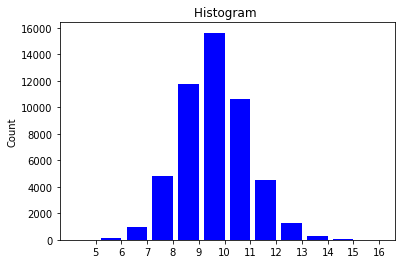

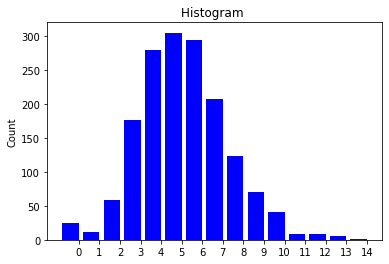

[0.125 0.055 0.29  0.885 1.395 1.525 1.47  1.035 0.62  0.35  0.205 0.04
 0.045 0.03  0.005 0.    0.   ]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e-03
 1.1900e-01 9.9500e-01 4.8070e+00 1.1745e+01 1.5621e+01 1.0594e+01
 4.4900e+00 1.2800e+00 2.9300e-01 4.7000e-02 4.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810152-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


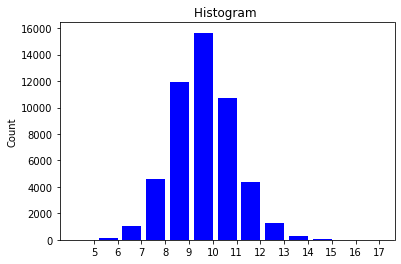

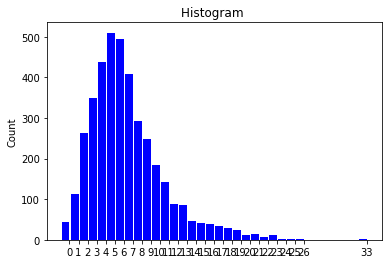

[0.22  0.565 1.31  1.74  2.19  2.55  2.47  2.04  1.46  1.24  0.915 0.715
 0.44  0.425 0.235 0.21  0.19  0.17  0.145 0.115 0.065 0.075 0.035 0.06
 0.015 0.01  0.005 0.005]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-03
 1.0600e-01 1.0340e+00 4.5810e+00 1.1947e+01 1.5656e+01 1.0704e+01
 4.3430e+00 1.3030e+00 2.6900e-01 3.9000e-02 1.3000e-02 1.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 115.99854175230867
Entropy 1.3842424092795431
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299411-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


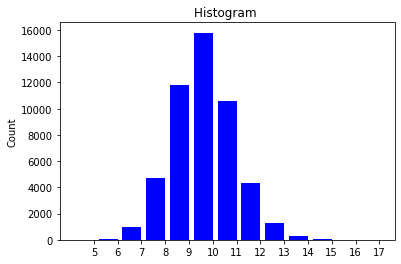

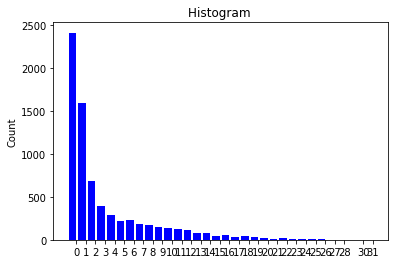

[1.2055e+01 7.9750e+00 3.4250e+00 1.9850e+00 1.4550e+00 1.1100e+00
 1.1250e+00 9.0500e-01 8.6500e-01 7.5500e-01 6.6500e-01 6.1500e-01
 5.6500e-01 3.8500e-01 4.2000e-01 2.0000e-01 3.0000e-01 1.8500e-01
 2.0000e-01 1.7500e-01 1.0500e-01 7.0000e-02 9.0000e-02 5.5000e-02
 2.0000e-02 3.5000e-02 2.0000e-02 1.5000e-02 1.0000e-02 1.0000e-02
 5.0000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e-03
 9.8000e-02 1.0080e+00 4.7070e+00 1.1783e+01 1.5797e+01 1.0613e+01
 4.3640e+00 1.2750e+00 2.9200e-01 4.7000e-02 8.0000e-03 3.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
KL-divergence 130.69480601813072
Entropy 2.279821008341123
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175786-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


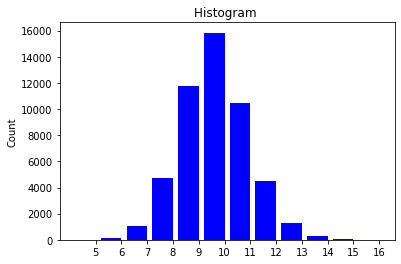

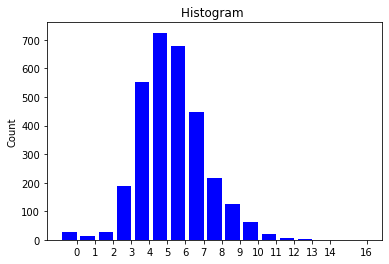

[0.13  0.06  0.145 0.95  2.77  3.625 3.4   2.23  1.075 0.62  0.315 0.095
 0.035 0.02  0.005 0.    0.005]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e-03
 1.1200e-01 1.0340e+00 4.6980e+00 1.1742e+01 1.5841e+01 1.0440e+01
 4.5020e+00 1.2940e+00 2.7800e-01 4.9000e-02 5.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175784-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


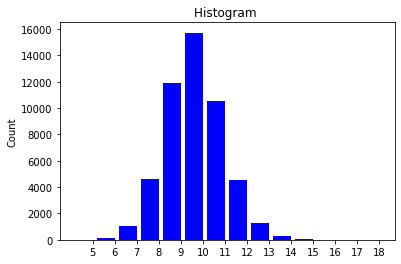

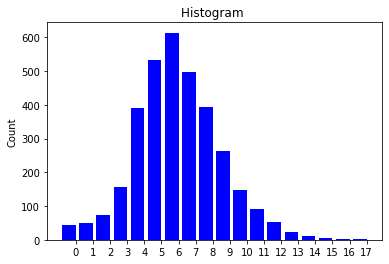

[0.215 0.255 0.375 0.785 1.96  2.665 3.07  2.495 1.975 1.31  0.745 0.455
 0.265 0.115 0.06  0.025 0.015 0.005 0.   ]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-03
 1.1800e-01 1.0150e+00 4.6460e+00 1.1881e+01 1.5721e+01 1.0502e+01
 4.5180e+00 1.2860e+00 2.5200e-01 4.0000e-02 1.4000e-02 2.0000e-03
 1.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589365179-generated-generate_seqs_watts_strogatz_dfs.json
Generated graphs: 200
Dataset graphs: 1000


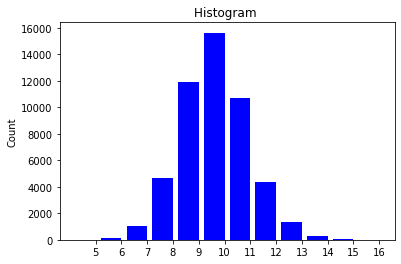

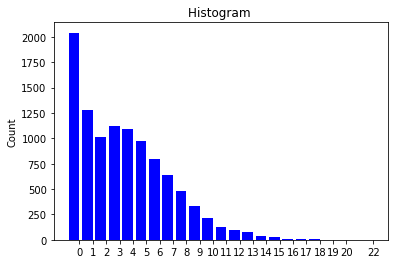

[1.0205e+01 6.4050e+00 5.0550e+00 5.6050e+00 5.4750e+00 4.8850e+00
 4.0000e+00 3.2100e+00 2.4100e+00 1.6900e+00 1.0600e+00 6.3500e-01
 4.6000e-01 3.6500e-01 1.8000e-01 1.2500e-01 5.0000e-02 3.0000e-02
 2.0000e-02 1.0000e-02 5.0000e-03 5.0000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e-03
 1.2700e-01 1.0240e+00 4.6450e+00 1.1882e+01 1.5622e+01 1.0671e+01
 4.3720e+00 1.3190e+00 2.8400e-01 4.7000e-02 4.0000e-03 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 108.3431900173856
Entropy 2.203870525976807
Degree entropy sufficiently small? False


In [29]:
for filepath in models_watts_strogatz_dfs:
    compare_model_infos(model_infos, filepath)

In [30]:
models_watts_strogatz_bfs = [name for name in models_watts_strogatz if '_bfs' in name]
models_watts_strogatz_bfs

['/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680745-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680739-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574322-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810142-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574324-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408181-generated-generate_seqs_watts_strogatz_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589365140-generated-generate_seqs_watts_strogatz_bfs.json']

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680745-generated-generate_seqs_watts_strogatz_bfs.json
Generated graphs: 200
Dataset graphs: 1000


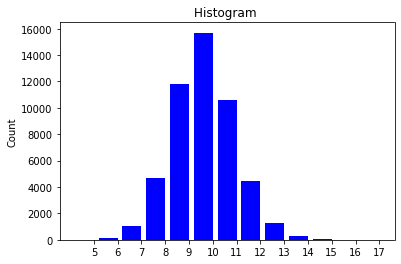

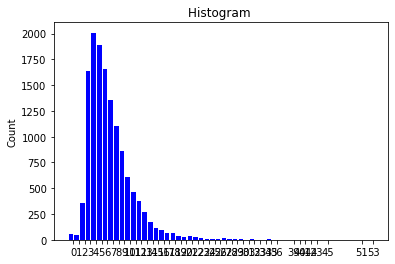

[2.9500e-01 2.4000e-01 1.7950e+00 8.1900e+00 1.0045e+01 9.4450e+00
 8.2950e+00 6.7650e+00 5.5000e+00 4.2900e+00 3.0500e+00 2.3250e+00
 1.8800e+00 1.3700e+00 8.5500e-01 5.6500e-01 4.5500e-01 3.3500e-01
 3.2500e-01 2.0000e-01 1.4000e-01 1.7000e-01 1.6000e-01 8.5000e-02
 5.5000e-02 5.0000e-02 3.5000e-02 6.5000e-02 2.0000e-02 3.5000e-02
 4.5000e-02 1.0000e-02 1.5000e-02 1.0000e-02 1.0000e-02 2.0000e-02
 1.0000e-02 5.0000e-03 5.0000e-03 1.0000e-02 1.0000e-02 1.0000e-02
 5.0000e-03 5.0000e-03 5.0000e-03]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e-03
 1.1700e-01 1.0620e+00 4.6840e+00 1.1780e+01 1.5694e+01 1.0573e+01
 4.4280e+00 1.3090e+00 2.9600e-01 4.8000e-02 5.0000e-03 1.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.00

/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


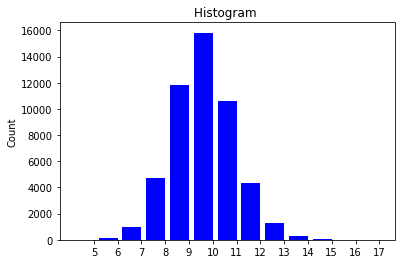

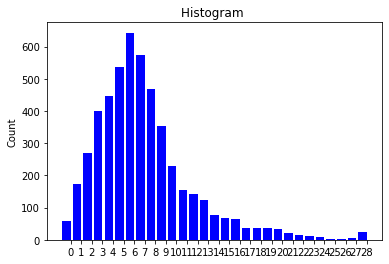

[0.295 0.86  1.345 1.995 2.225 2.685 3.215 2.865 2.34  1.76  1.14  0.78
 0.705 0.62  0.385 0.345 0.325 0.19  0.185 0.19  0.16  0.1   0.07  0.06
 0.04  0.015 0.01  0.025 0.115]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e-03
 1.0900e-01 9.5900e-01 4.6970e+00 1.1854e+01 1.5822e+01 1.0569e+01
 4.3410e+00 1.3030e+00 2.8300e-01 4.5000e-02 1.0000e-02 2.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 102.2276170106829
Entropy 1.3532035415950927
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574322-generated-generate_seqs_watts_strogatz_bfs.json
Generated graphs: 200
Dataset graphs: 1000


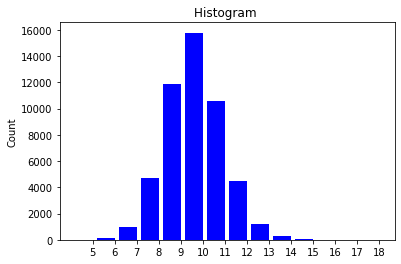

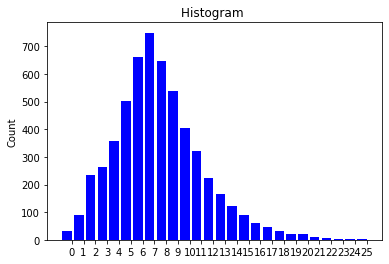

[0.165 0.45  1.17  1.325 1.79  2.515 3.305 3.745 3.23  2.685 2.02  1.6
 1.125 0.83  0.61  0.45  0.295 0.225 0.165 0.105 0.1   0.055 0.025 0.015
 0.01  0.01 ]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-03
 1.1900e-01 9.5400e-01 4.6950e+00 1.1876e+01 1.5775e+01 1.0548e+01
 4.4570e+00 1.2050e+00 3.0100e-01 5.6000e-02 8.0000e-03 1.0000e-03
 1.0000e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
KL-divergence 76.21985073897822
Entropy 0.9452925502602791
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810142-generated-generate_seqs_watts_strogatz_bfs.json
Generated graphs: 200
Dataset graphs: 1000


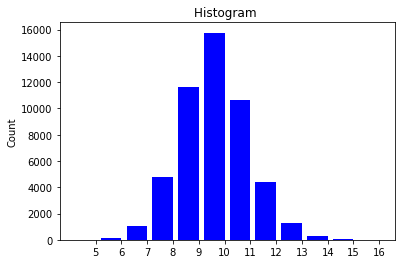

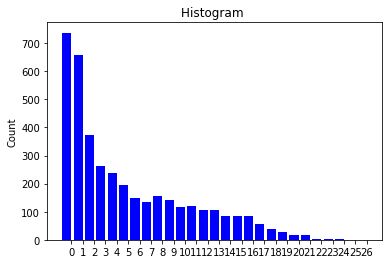

[3.685 3.28  1.865 1.31  1.19  0.97  0.745 0.67  0.78  0.715 0.59  0.605
 0.525 0.53  0.42  0.42  0.43  0.29  0.2   0.135 0.09  0.085 0.02  0.015
 0.01  0.005 0.005]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e-03
 1.1000e-01 1.0400e+00 4.7500e+00 1.1640e+01 1.5766e+01 1.0636e+01
 4.4250e+00 1.3040e+00 2.7600e-01 4.3000e-02 3.0000e-03 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 133.93607364581925
Entropy 1.7414624346060334
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574324-generated-generate_seqs_watts_strogatz_bfs.json
Generated graphs: 200
Dataset graphs: 1000


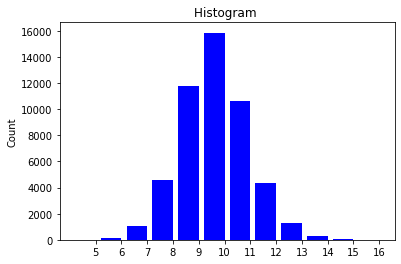

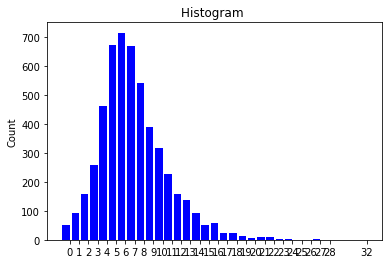

[0.255 0.465 0.795 1.29  2.305 3.355 3.57  3.345 2.695 1.95  1.59  1.14
 0.795 0.68  0.465 0.255 0.295 0.125 0.12  0.07  0.035 0.05  0.045 0.02
 0.02  0.005 0.005 0.01  0.005 0.005]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e-03
 1.1500e-01 1.0820e+00 4.6040e+00 1.1739e+01 1.5849e+01 1.0600e+01
 4.3780e+00 1.2690e+00 3.0200e-01 5.7000e-02 2.0000e-03 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 90.01454609884435
Entropy 1.1370908177848933
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408181-generated-generate_seqs_watts_strogatz_bfs.json
Generated graphs: 200
Dataset graphs: 1000


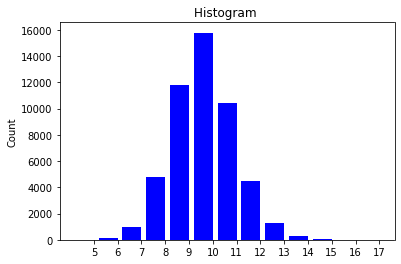

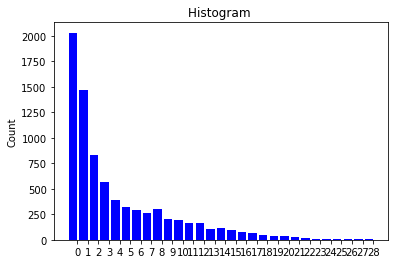

[10.15   7.36   4.14   2.85   1.945  1.59   1.455  1.33   1.51   1.04
  0.99   0.845  0.83   0.545  0.58   0.48   0.375  0.31   0.25   0.17
  0.2    0.145  0.075  0.025  0.03   0.035  0.035  0.025  0.02 ]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e-03
 1.1300e-01 9.8600e-01 4.7730e+00 1.1782e+01 1.5791e+01 1.0424e+01
 4.4940e+00 1.2830e+00 2.8600e-01 5.6000e-02 7.0000e-03 3.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence 111.74342850548845
Entropy 1.9949602724628288
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589365140-generated-generate_seqs_watts_strogatz_bfs.json
Generated graphs: 200
Dataset graphs: 1000


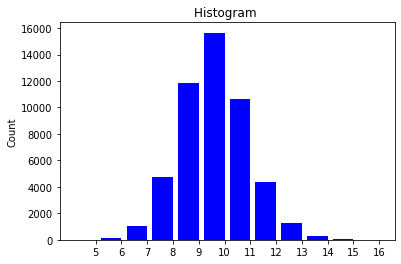

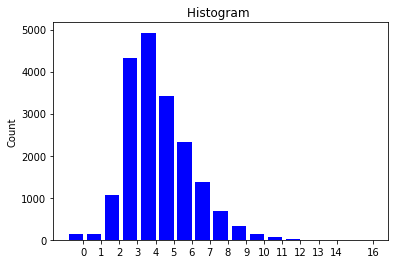

[7.0500e-01 7.3000e-01 5.3050e+00 2.1625e+01 2.4625e+01 1.7145e+01
 1.1590e+01 6.8150e+00 3.4350e+00 1.6250e+00 6.8000e-01 3.0500e-01
 1.2000e-01 3.5000e-02 2.5000e-02 0.0000e+00 1.0000e-02]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e-03
 1.2700e-01 1.0060e+00 4.7080e+00 1.1824e+01 1.5647e+01 1.0654e+01
 4.3700e+00 1.2970e+00 3.0900e-01 4.8000e-02 5.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False


/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


In [31]:
for filepath in models_watts_strogatz_bfs:
    compare_model_infos(model_infos, filepath)

# Barabasi Albert

In [32]:
models_barabasi_albert

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473704-generated-generate_seqs_barabasi_albert_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473681-generated-generate_seqs_barabasi_albert_process.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408156-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680741-generated-generate_seqs_barabasi_albert_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574350-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299685-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408162-generated-generate_seqs_barabasi_albert_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414138-g

In [33]:
models_barabasi_albert_process = [name for name in models_barabasi_albert if '_process' in name]
models_barabasi_albert_process

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473681-generated-generate_seqs_barabasi_albert_process.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680733-generated-generate_seqs_barabasi_albert_process.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175789-generated-generate_seqs_barabasi_albert_process.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175785-generated-generate_seqs_barabasi_albert_process.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680729-generated-generate_seqs_barabasi_albert_process.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590574333-generated-generate_seqs_barabasi_albert_process.json']

/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473681-generated-generate_seqs_barabasi_albert_process.json
Generated graphs: 200
Dataset graphs: 1000


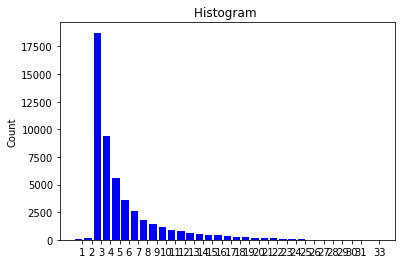

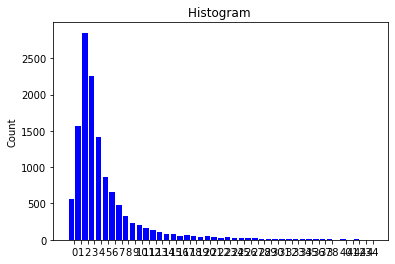

[2.8200e+00 7.8150e+00 1.4255e+01 1.1285e+01 7.0950e+00 4.3250e+00
 3.3200e+00 2.3650e+00 1.6600e+00 1.1750e+00 1.0200e+00 7.8000e-01
 6.9000e-01 5.6500e-01 4.0000e-01 3.8000e-01 2.9000e-01 3.6000e-01
 2.7000e-01 2.1500e-01 2.6500e-01 1.7000e-01 1.4000e-01 1.8000e-01
 9.5000e-02 1.3500e-01 1.3500e-01 1.3000e-01 8.5000e-02 4.0000e-02
 6.5000e-02 5.0000e-02 6.0000e-02 3.5000e-02 4.5000e-02 3.0000e-02
 2.5000e-02 3.5000e-02 2.5000e-02 2.5000e-02 5.0000e-03 2.5000e-02
 5.0000e-03 5.0000e-03]
[0.0000e+00 1.1200e-01 1.4400e-01 1.8747e+01 9.4180e+00 5.5680e+00
 3.6010e+00 2.5920e+00 1.8320e+00 1.4250e+00 1.1980e+00 8.8800e-01
 8.1300e-01 6.5000e-01 5.6800e-01 4.7500e-01 4.2600e-01 3.1800e-01
 2.8500e-01 2.2100e-01 1.8100e-01 1.4500e-01 1.3300e-01 8.4000e-02
 6.4000e-02 4.2000e-02 2.4000e-02 1.8000e-02 1.0000e-02 1.0000e-02
 5.0000e-03 2.0000e-03 0.0000e+00 1.0000e-03 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
KL-divergence 

/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


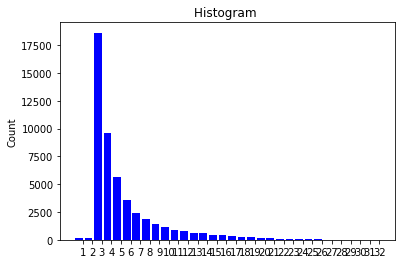

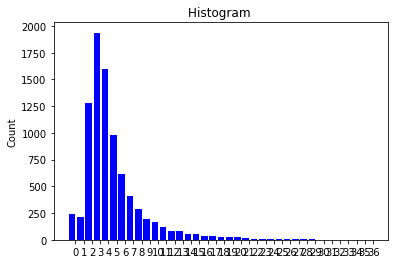

[1.215e+00 1.065e+00 6.405e+00 9.685e+00 7.965e+00 4.910e+00 3.095e+00
 2.070e+00 1.425e+00 9.600e-01 8.250e-01 6.150e-01 4.100e-01 4.050e-01
 2.600e-01 2.600e-01 1.800e-01 2.000e-01 1.100e-01 1.400e-01 1.200e-01
 7.500e-02 5.500e-02 5.500e-02 5.500e-02 2.000e-02 4.000e-02 2.500e-02
 1.500e-02 3.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 5.000e-03 5.000e-03]
[0.0000e+00 1.3500e-01 1.4600e-01 1.8617e+01 9.5900e+00 5.6240e+00
 3.5860e+00 2.4530e+00 1.8490e+00 1.4410e+00 1.1780e+00 9.1800e-01
 7.9400e-01 6.4200e-01 5.8400e-01 4.7400e-01 3.9300e-01 3.2400e-01
 2.7400e-01 2.3200e-01 2.0500e-01 1.4300e-01 1.0900e-01 1.0800e-01
 6.7000e-02 3.7000e-02 2.8000e-02 2.0000e-02 1.4000e-02 1.1000e-02
 2.0000e-03 1.0000e-03 1.0000e-03 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
KL-divergence 19.43743373399342
Entropy 0.23209486463449186
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175789-generated-generate_seqs_baraba

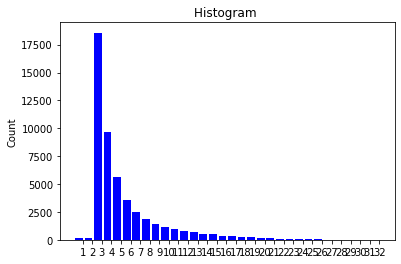

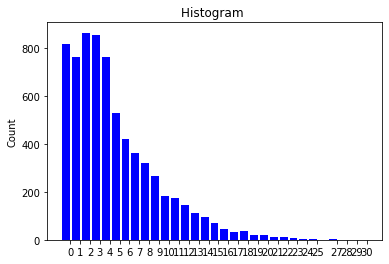

[4.075 3.82  4.32  4.28  3.81  2.635 2.105 1.815 1.595 1.335 0.91  0.875
 0.735 0.565 0.485 0.36  0.225 0.165 0.19  0.09  0.1   0.05  0.06  0.035
 0.02  0.01  0.    0.01  0.005 0.005 0.005 0.    0.   ]
[0.0000e+00 1.2300e-01 1.5600e-01 1.8569e+01 9.6380e+00 5.6100e+00
 3.5760e+00 2.4710e+00 1.8470e+00 1.4040e+00 1.1690e+00 9.5600e-01
 8.2100e-01 6.9300e-01 5.3700e-01 4.8400e-01 3.8500e-01 3.3500e-01
 2.7700e-01 2.2700e-01 1.9200e-01 1.5300e-01 1.0100e-01 8.6000e-02
 7.2000e-02 4.5000e-02 3.1000e-02 1.6000e-02 1.2000e-02 1.1000e-02
 1.0000e-03 1.0000e-03 1.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175785-generated-generate_seqs_barabasi_albert_process.json
Generated graphs: 200
Dataset graphs: 1000


/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


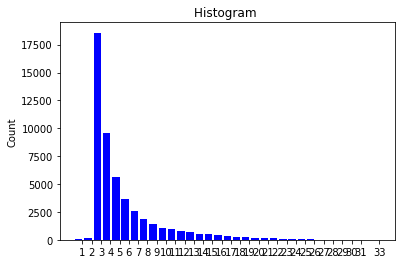

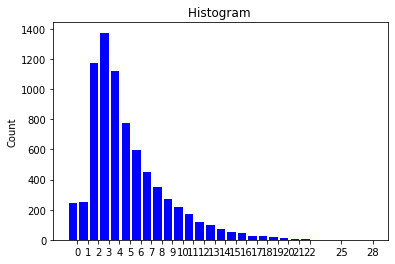

[1.210e+00 1.240e+00 5.855e+00 6.875e+00 5.615e+00 3.890e+00 2.965e+00
 2.255e+00 1.755e+00 1.350e+00 1.075e+00 8.500e-01 5.850e-01 4.750e-01
 3.450e-01 2.600e-01 2.100e-01 1.250e-01 1.150e-01 8.500e-02 6.000e-02
 4.000e-02 1.500e-02 0.000e+00 0.000e+00 5.000e-03 0.000e+00 0.000e+00
 5.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[0.0000e+00 1.0800e-01 1.5700e-01 1.8569e+01 9.5780e+00 5.5870e+00
 3.6900e+00 2.5720e+00 1.8430e+00 1.3950e+00 1.0860e+00 9.7600e-01
 7.7400e-01 6.6100e-01 5.2000e-01 4.8800e-01 4.0600e-01 3.3600e-01
 2.6100e-01 2.5900e-01 1.9800e-01 1.4800e-01 1.2700e-01 9.3000e-02
 6.1000e-02 3.8000e-02 3.5000e-02 1.6000e-02 9.0000e-03 6.0000e-03
 1.0000e-03 1.0000e-03 1.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680729-generated-generate_seqs_barabasi_albert_process.json
Generated graphs: 200
Dataset graphs: 1000


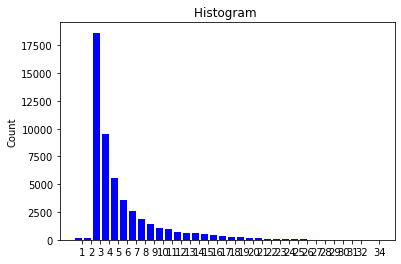

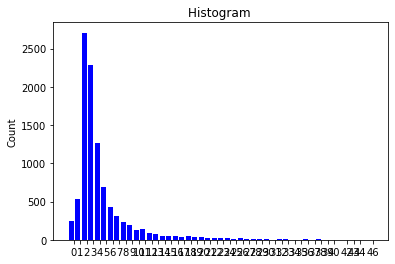

[1.250e+00 2.665e+00 1.354e+01 1.141e+01 6.325e+00 3.480e+00 2.175e+00
 1.565e+00 1.145e+00 9.600e-01 6.450e-01 6.950e-01 4.500e-01 3.500e-01
 2.600e-01 2.500e-01 2.550e-01 1.950e-01 2.250e-01 1.950e-01 1.550e-01
 1.050e-01 8.500e-02 1.400e-01 9.500e-02 5.500e-02 9.500e-02 5.500e-02
 3.000e-02 5.000e-02 4.000e-02 1.500e-02 4.000e-02 4.000e-02 5.000e-03
 1.500e-02 2.000e-02 1.500e-02 2.000e-02 5.000e-03 5.000e-03 5.000e-03
 1.000e-02 1.000e-02 5.000e-03]
[0.000e+00 1.410e-01 1.440e-01 1.864e+01 9.532e+00 5.547e+00 3.612e+00
 2.575e+00 1.903e+00 1.417e+00 1.103e+00 9.530e-01 7.120e-01 6.490e-01
 6.030e-01 5.020e-01 3.990e-01 3.490e-01 2.720e-01 2.220e-01 1.830e-01
 1.530e-01 1.010e-01 9.000e-02 7.400e-02 4.700e-02 3.000e-02 2.400e-02
 1.000e-02 5.000e-03 4.000e-03 2.000e-03 1.000e-03 0.000e+00 1.000e-03
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
KL-divergence 22.09246038329089
Entropy 0.4247030488308476
Degree entropy sufficient

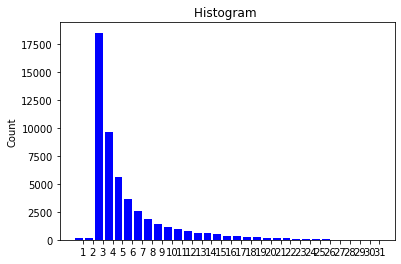

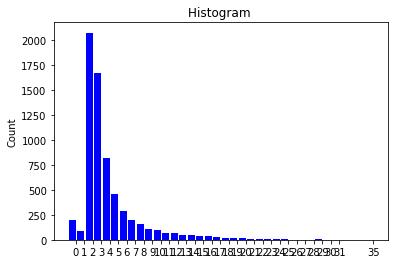

[9.950e-01 4.550e-01 1.036e+01 8.330e+00 4.095e+00 2.300e+00 1.445e+00
 9.750e-01 7.800e-01 5.300e-01 4.900e-01 3.400e-01 3.350e-01 2.250e-01
 2.650e-01 1.850e-01 2.000e-01 1.400e-01 1.050e-01 7.000e-02 1.050e-01
 6.500e-02 4.000e-02 4.000e-02 4.500e-02 2.500e-02 1.500e-02 1.000e-02
 1.000e-02 2.000e-02 1.500e-02 5.000e-03 5.000e-03]
[0.0000e+00 1.4300e-01 1.6300e-01 1.8496e+01 9.6040e+00 5.6340e+00
 3.6050e+00 2.5820e+00 1.8220e+00 1.3700e+00 1.1500e+00 9.9000e-01
 8.2700e-01 6.2600e-01 5.7200e-01 4.8200e-01 3.6000e-01 3.3800e-01
 2.6800e-01 2.2900e-01 1.8900e-01 1.5300e-01 1.2000e-01 8.0000e-02
 7.4000e-02 5.2000e-02 3.0000e-02 1.9000e-02 8.0000e-03 1.1000e-02
 2.0000e-03 1.0000e-03 0.0000e+00]
KL-divergence 41.68708715139114
Entropy 0.418832176091659
Degree entropy sufficiently small? False


In [34]:
for filepath in models_barabasi_albert_process:
    compare_model_infos(model_infos, filepath)

In [22]:
models_barabasi_albert_dfs = [name for name in models_barabasi_albert if '_dfs' in name]
models_barabasi_albert_dfs

['/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408156-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299685-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414138-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414072-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408015-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175784-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408179-generated-generate_seqs_barabasi_albert_dfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810140-generated-g

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408156-generated-generate_seqs_barabasi_albert_dfs.json


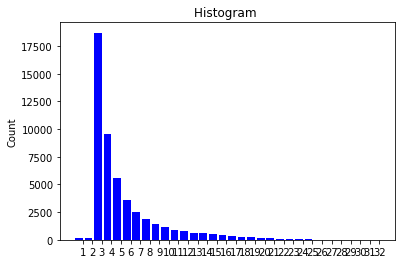

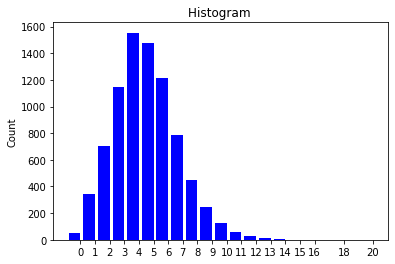

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589299685-generated-generate_seqs_barabasi_albert_dfs.json


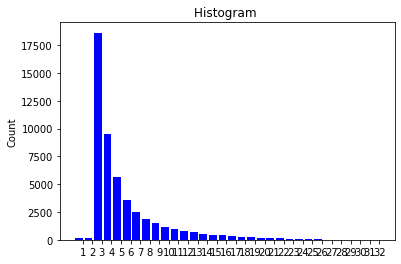

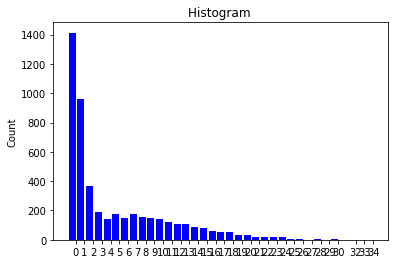

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414138-generated-generate_seqs_barabasi_albert_dfs.json


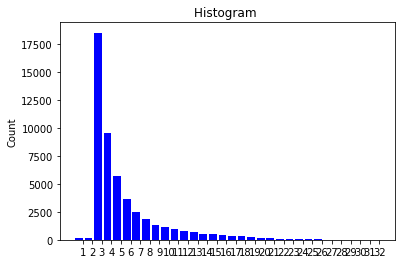

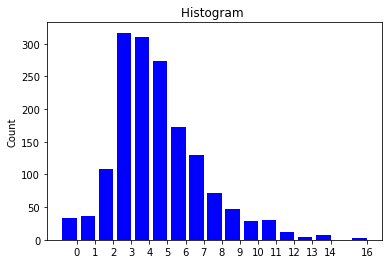

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590414072-generated-generate_seqs_barabasi_albert_dfs.json


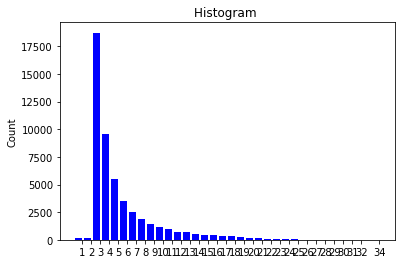

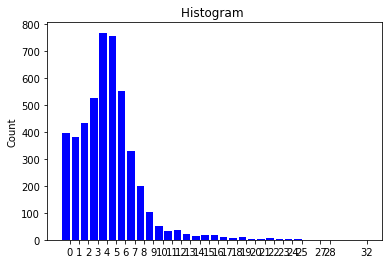

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408015-generated-generate_seqs_barabasi_albert_dfs.json


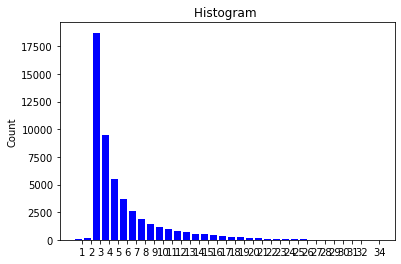

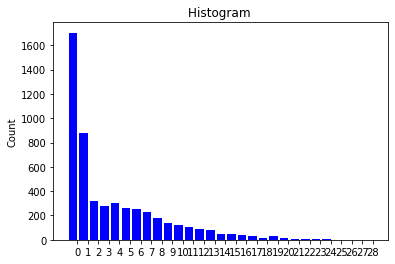

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175784-generated-generate_seqs_barabasi_albert_dfs.json


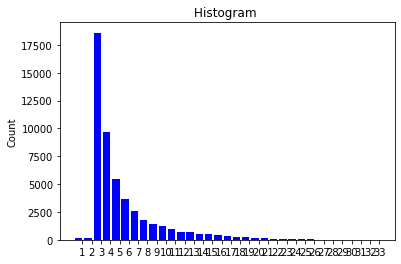

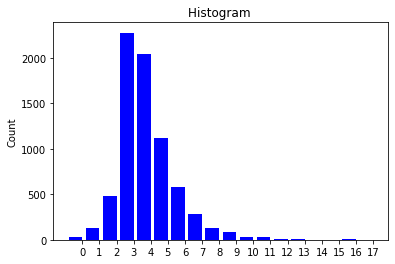

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408179-generated-generate_seqs_barabasi_albert_dfs.json


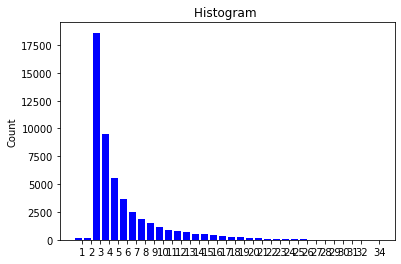

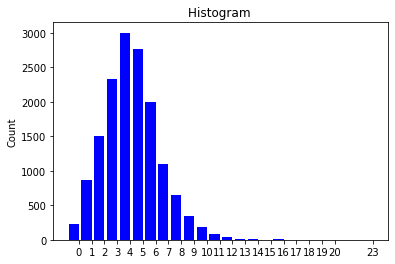

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810140-generated-generate_seqs_barabasi_albert_dfs.json


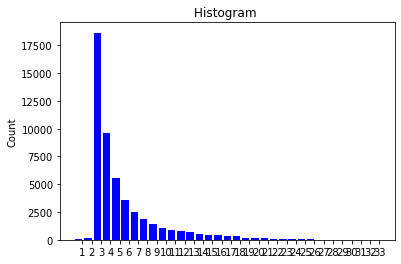

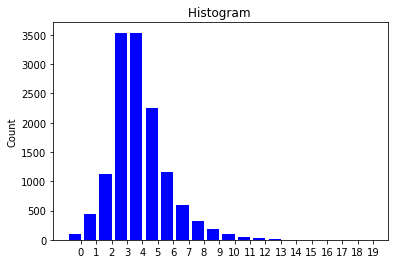

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408078-generated-generate_seqs_barabasi_albert_dfs.json


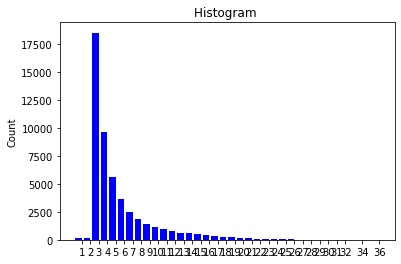

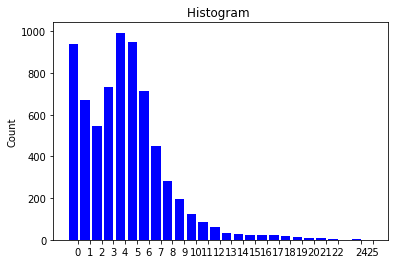

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590175787-generated-generate_seqs_barabasi_albert_dfs.json


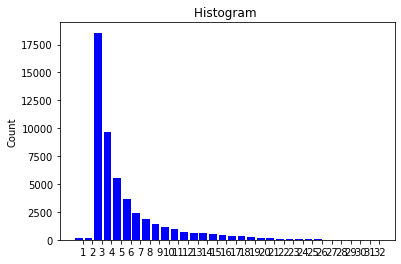

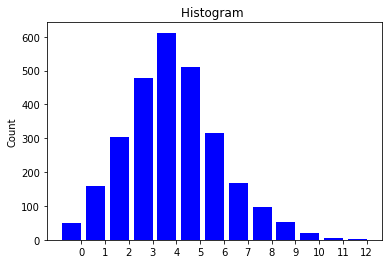

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1589810138-generated-generate_seqs_barabasi_albert_dfs.json


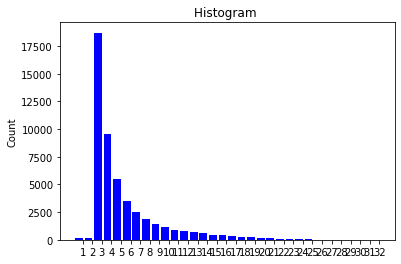

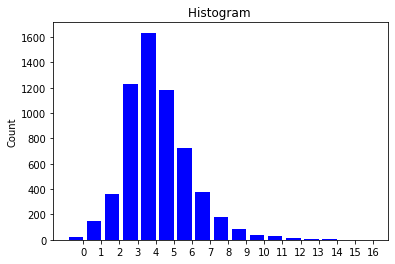

/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590412768-generated-generate_seqs_barabasi_albert_dfs.json


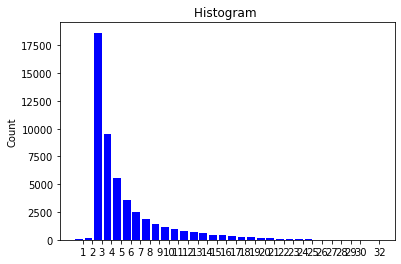

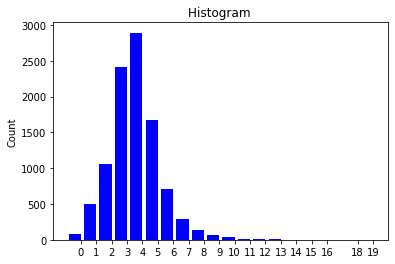

In [23]:
for filepath in models_barabasi_albert_dfs:
    print(filepath)
    generated_graphs_degree = count_graphs_degree(model_infos[filepath]['graphs'])
    ds_graphs_degree = count_graphs_degree(model_infos[filepath]['ds_graphs'])
    
    plot_count(ds_graphs_degree)
    plot_count(generated_graphs_degree)

In [35]:
models_barabasi_albert_bfs = [name for name in models_barabasi_albert if '_bfs' in name]
models_barabasi_albert_bfs

['/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473704-generated-generate_seqs_barabasi_albert_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680741-generated-generate_seqs_barabasi_albert_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408162-generated-generate_seqs_barabasi_albert_bfs.json',
 '/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408184-generated-generate_seqs_barabasi_albert_bfs.json']

/media/data/computations/inn02-deep-graph-learning/mackenzie/deepgg-t1589473704-generated-generate_seqs_barabasi_albert_bfs.json
Generated graphs: 200
Dataset graphs: 1000


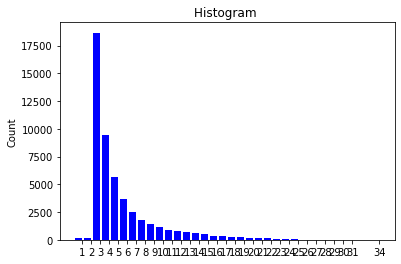

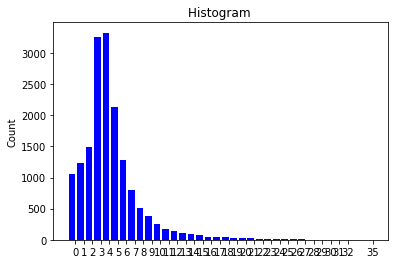

[5.2950e+00 6.1650e+00 7.4850e+00 1.6300e+01 1.6625e+01 1.0685e+01
 6.4000e+00 3.9650e+00 2.5900e+00 1.8850e+00 1.3050e+00 8.4500e-01
 6.7500e-01 5.4500e-01 4.5000e-01 3.5500e-01 2.0500e-01 2.4000e-01
 1.9000e-01 1.0500e-01 1.4500e-01 1.0500e-01 9.5000e-02 7.0000e-02
 5.5000e-02 5.0000e-02 3.0000e-02 2.5000e-02 1.5000e-02 2.0000e-02
 1.5000e-02 5.0000e-03 5.0000e-03 0.0000e+00 5.0000e-03]
[0.0000e+00 1.2700e-01 1.6300e-01 1.8657e+01 9.4500e+00 5.6180e+00
 3.7110e+00 2.5290e+00 1.7510e+00 1.4320e+00 1.1750e+00 9.2100e-01
 7.8300e-01 6.6900e-01 5.6800e-01 4.8100e-01 3.6000e-01 3.6100e-01
 2.8500e-01 2.2800e-01 1.8600e-01 1.5300e-01 1.2200e-01 7.9000e-02
 6.9000e-02 4.7000e-02 2.6000e-02 2.4000e-02 1.1000e-02 4.0000e-03
 5.0000e-03 4.0000e-03 0.0000e+00 1.0000e-03 0.0000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590680741-generated-generate_seqs_barabasi_albert_bfs.json
Generated graphs: 2

/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


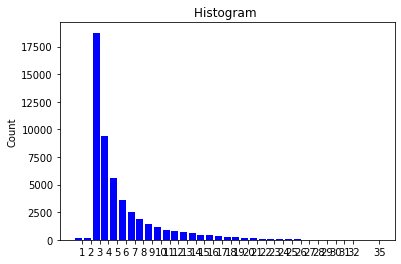

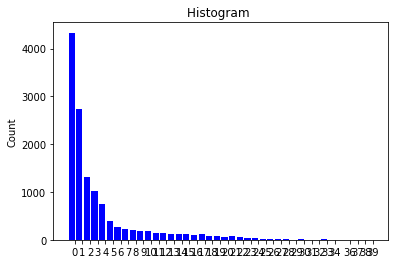

[2.1665e+01 1.3685e+01 6.5950e+00 5.1200e+00 3.7450e+00 2.0150e+00
 1.3700e+00 1.1150e+00 9.9500e-01 9.0500e-01 9.2500e-01 7.5000e-01
 6.6500e-01 6.4500e-01 5.9500e-01 5.9500e-01 5.3500e-01 5.9500e-01
 4.4000e-01 4.0000e-01 3.3000e-01 3.5000e-01 2.8000e-01 2.1500e-01
 1.4500e-01 1.0000e-01 1.1000e-01 8.5000e-02 1.1000e-01 3.0000e-02
 5.0000e-02 1.5000e-02 2.5000e-02 3.5000e-02 1.0000e-02 0.0000e+00
 2.0000e-02 2.0000e-02 1.0000e-02 1.5000e-02]
[0.0000e+00 1.1900e-01 1.4500e-01 1.8759e+01 9.3860e+00 5.6310e+00
 3.5950e+00 2.5310e+00 1.8710e+00 1.4000e+00 1.1220e+00 9.0800e-01
 8.2200e-01 7.0100e-01 5.7500e-01 4.7900e-01 4.0400e-01 3.5400e-01
 2.7300e-01 2.2200e-01 1.8600e-01 1.3800e-01 1.1400e-01 7.9000e-02
 5.7000e-02 4.7000e-02 3.5000e-02 2.0000e-02 1.1000e-02 7.0000e-03
 5.0000e-03 2.0000e-03 1.0000e-03 0.0000e+00 0.0000e+00 1.0000e-03
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-de

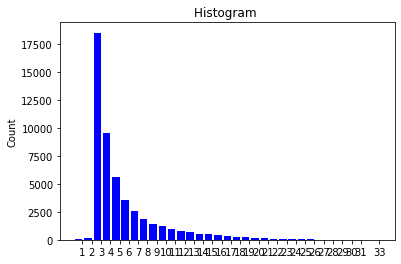

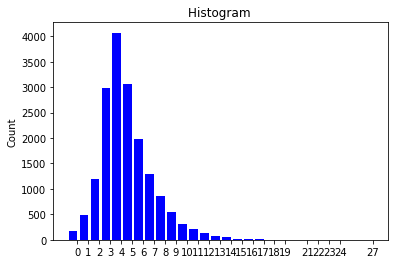

[8.4500e-01 2.3900e+00 5.9700e+00 1.4955e+01 2.0355e+01 1.5330e+01
 9.9350e+00 6.4450e+00 4.2700e+00 2.7400e+00 1.5800e+00 1.0800e+00
 6.4500e-01 4.1500e-01 2.9000e-01 1.1500e-01 6.0000e-02 5.5000e-02
 2.5000e-02 2.5000e-02 0.0000e+00 1.0000e-02 1.0000e-02 1.5000e-02
 1.0000e-02 0.0000e+00 0.0000e+00 5.0000e-03 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
[0.0000e+00 1.1100e-01 1.4500e-01 1.8556e+01 9.5890e+00 5.6600e+00
 3.5260e+00 2.5470e+00 1.8580e+00 1.4110e+00 1.2160e+00 9.4100e-01
 7.9500e-01 6.9300e-01 5.2500e-01 4.9200e-01 4.0700e-01 3.0800e-01
 2.7100e-01 2.4100e-01 2.0600e-01 1.3600e-01 1.0600e-01 8.6000e-02
 6.3000e-02 4.2000e-02 2.9000e-02 1.8000e-02 1.1000e-02 3.0000e-03
 3.0000e-03 3.0000e-03 2.0000e-03]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False
/media/data/computations/inn02-deep-graph-learning/drogon/deepgg-t1590408184-generated-generate_seqs_barabasi_albert_bfs.json
Generated graphs: 200
Dataset graphs: 1000


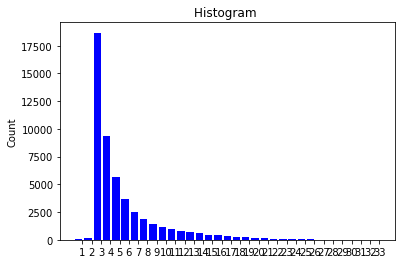

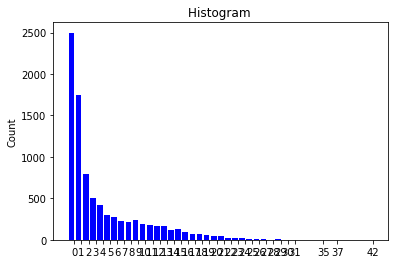

[1.249e+01 8.715e+00 3.980e+00 2.515e+00 2.080e+00 1.510e+00 1.375e+00
 1.120e+00 1.080e+00 1.195e+00 9.800e-01 8.900e-01 8.550e-01 8.550e-01
 5.900e-01 6.600e-01 4.650e-01 3.750e-01 3.650e-01 2.800e-01 2.550e-01
 2.300e-01 1.250e-01 8.500e-02 1.150e-01 7.500e-02 4.500e-02 4.500e-02
 1.000e-02 2.000e-02 1.000e-02 1.000e-02 0.000e+00 0.000e+00 5.000e-03
 5.000e-03 5.000e-03]
[0.0000e+00 1.1500e-01 1.5900e-01 1.8674e+01 9.3670e+00 5.6220e+00
 3.7190e+00 2.5250e+00 1.8330e+00 1.4490e+00 1.1420e+00 9.3500e-01
 8.0500e-01 6.6200e-01 5.7000e-01 4.7300e-01 4.4400e-01 3.4300e-01
 2.5700e-01 2.1600e-01 1.5900e-01 1.3700e-01 1.1500e-01 8.4000e-02
 6.6000e-02 3.9000e-02 3.4000e-02 1.8000e-02 1.5000e-02 1.0000e-02
 6.0000e-03 2.0000e-03 3.0000e-03 2.0000e-03 0.0000e+00 0.0000e+00
 0.0000e+00]
KL-divergence inf
Entropy inf
Degree entropy sufficiently small? False


In [36]:
for filepath in models_barabasi_albert_bfs:
    compare_model_infos(model_infos, filepath)